In [20]:
pip install scipy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 32.4 MB/s eta 0:00:0000:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 23.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
# Given parameters
L = 3.34e5  # Latent heat of phase change (KJ/m^3)
C_i = 1.672  # Heat capacity of ice (KJ/(m^3·K))
C_l = 4.18  # Heat capacity of water (KJ/(m^3·K))
lambda_i = 2.210  # Thermal conductivity of ice (W/(m·K))
lambda_l = 0.465  # Thermal conductivity of water (W/(m·K))

# Unknown parameters
lambda_f = 1.5  # Thermal conductivity of soil matrix (W/(m·K))
C_f = 1.5  # Heat capacity of soil matrix (KJ/(m^3·K))
eta = 0.4  # Porosity of the soil
b = 1.5  # Coefficient for unfrozen water content
T_nabla = -1 # Freezing temperature of the soil (°C)

# Discretization parameters
Nx = 50  # Number of spatial points
Nt = 100000  # Number of time steps
Lx = 5.0  # Length of the domain (m) (from 0 m to 5.0 m)
T_total = 365.0  # Total time (days)
# T_total = 180.0  # Total time (days)
dx = Lx / (Nx - 1)  # Spatial step size
dt = T_total / Nt  # Time step size

# Define functions
def pore_water_content(T, T_nabla, b):
    """Calculate pore water content."""
    return np.where(T >= T_nabla, 1, np.abs(T_nabla)**b * np.abs(T)**(-b))

def unfrozen_water_content(T, T_nabla, b, eta):
    """Calculate unfrozen water content."""
    phi = pore_water_content(T, T_nabla, b)
    return eta * phi

def effective_concentration(C_f, C_l, C_i, eta, phi):
    """Calculate effective heat capacity."""
    C_t_value = C_f + eta * (C_l - C_i)
    return phi * C_t_value + (1 - phi) * C_f

def effective_lambda(lambda_f, lambda_l, lambda_i, eta, phi):
    """Calculate effective thermal conductivity."""
    lambda_t_value = lambda_f * (lambda_l / lambda_i) ** eta
    return lambda_t_value ** phi * lambda_f ** (1 - phi)

# Boundary condition function
def temperature(t):
    """Boundary temperature function at x=0."""
    return 4.03 + 16.11 * np.sin((2 * np.pi * t / 365) - 1.709)  # Temperature in °C

# Linear interpolation function
def linear_interpolation(z, z1, z2, T1, T2):
    """
    Linear interpolation to calculate temperature at depth z.
    """
    if z1 == z2:
        raise ValueError("z1 and z2 cannot be the same.")
    return T1 + (T2 - T1) / (z2 - z1) * (z - z1)

# Initialize temperature profile using linear interpolation
def initialize_temperature_profile(depths, z1, z2, T1, T2):
    """
    Initialize temperature profile using linear interpolation.
    """
    temperatures = np.zeros_like(depths)
    for i, z in enumerate(depths):
        temperatures[i] = linear_interpolation(z, z1, z2, T1, T2)
    return temperatures

# Define spatial grid
x = np.linspace(0, Lx, Nx)  # Spatial grid from 0 m to 5.0 m

# Define boundary conditions for interpolation
z1, T1 = 0.0, temperature(0)  # Upper boundary condition at x=0 m
z2, T2 = Lx, 1.0  # Lower boundary condition at x=5.0 m (1 °C)

# Initialize temperature profile
T = initialize_temperature_profile(x, z1, z2, T1, T2)

# Initialize the temperature field as a 2D array
T_field = np.zeros((Nx, Nt))  # Temperature field: T(x, t)
T_field[:, 0] = T  # Set initial condition

# Time-stepping loop
for n in range(Nt):
    t_n = n * dt
    
    # Apply Dirichlet boundary conditions
    T[0] = temperature(t_n)  # Upper boundary condition at x=0 m
    T[-1] = 1.0  # Lower boundary condition at x=5.0 m (1 °C)
    
    
    # Compute effective properties
    phi = pore_water_content(T, T_nabla, b)
    theta = unfrozen_water_content(T, T_nabla, b, eta)
    C_eff = effective_concentration(C_f, C_l, C_i, eta, phi)
    lambda_eff = effective_lambda(lambda_f, lambda_l, lambda_i, eta, phi)
    
    # Debugging: Print intermediate values
    if np.any(np.isnan(C_eff)) or np.any(np.isnan(lambda_eff)):
        print(f"Warning: NaN detected at t = {t_n}")
        print("C_eff:", C_eff)
        print("lambda_eff:", lambda_eff)
        break
    
    # Compute the right-hand side of the discretized equation
    rhs = np.zeros(Nx)
    for i in range(1, Nx-1):
        lambda_plus = 0.5 * (lambda_eff[i] + lambda_eff[i+1])
        lambda_minus = 0.5 * (lambda_eff[i] + lambda_eff[i-1])
        rhs[i] = (lambda_plus * (T[i+1] - T[i]) - lambda_minus * (T[i] - T[i-1])) / dx**2
    
    # Update temperature
    T[1:-1] += dt * (rhs[1:-1] - L * (theta[1:-1] - theta[1:-1]) / dt) / C_eff[1:-1]
    
    # Store the temperature field at the current time step
    T_field[:, n] = T


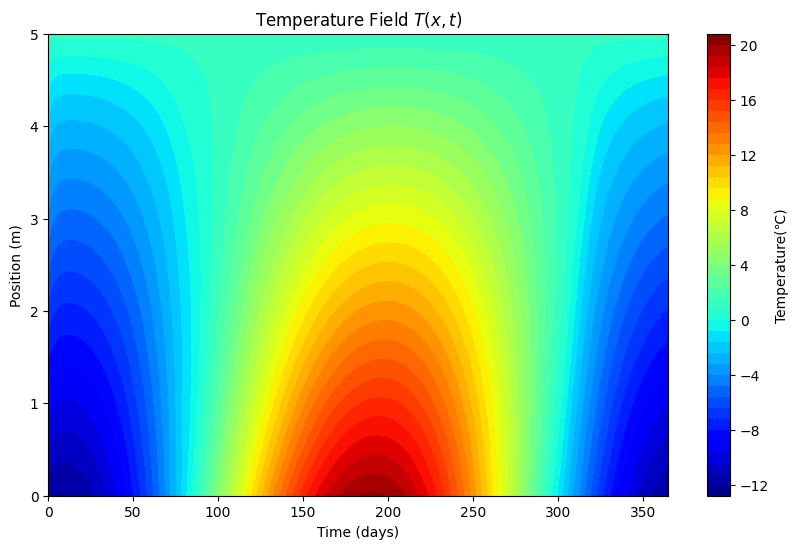

<Figure size 640x480 with 0 Axes>

In [4]:
# Plot the temperature field as a 2D image
plt.figure(figsize=(10, 6))
# analytical solutions
plt.contourf(np.linspace(0, T_total, Nt), x, T_field, levels=50, cmap='jet')
plt.colorbar(label='Temperature(℃)')
plt.xlabel('Time (days)')
plt.ylabel('Depth (m)')
plt.title('FDM Solution')
plt.xlabel('Time (days)')
plt.ylabel('Position (m)')
plt.title('Temperature Field $T(x, t)$')
plt.show()

# Save the plot as an image
plt.savefig('temperature_field_dirichlet.png', dpi=300, bbox_inches='tight')

In [5]:
T_field_FDM = T_field.shape;

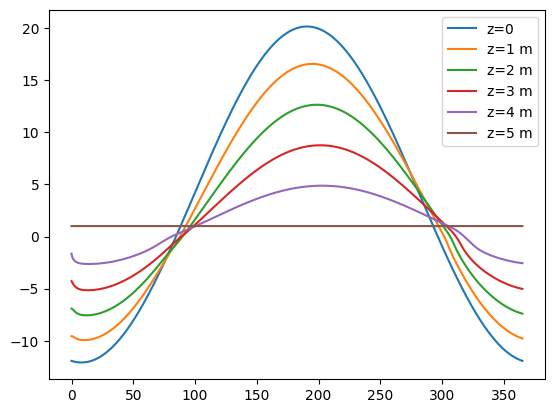

In [6]:
plt.plot(np.linspace(0, T_total, Nt),T_field[0,:],label = 'z=0')
plt.plot(np.linspace(0, T_total, Nt),T_field[9,:],label = 'z=1 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[19,:],label = 'z=2 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[29,:],label = 'z=3 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[39,:],label = 'z=4 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[49,:],label = 'z=5 m')
plt.legend()

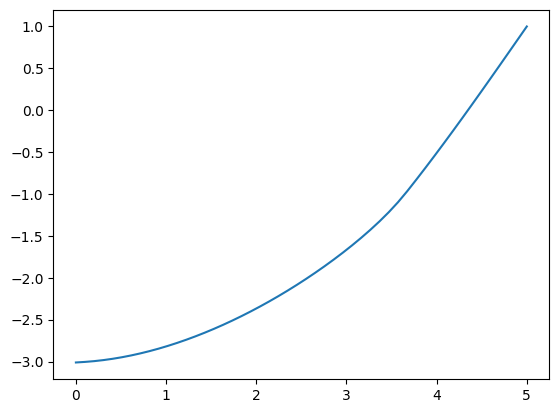

In [7]:
plt.plot(x,T_field[:,20000])

FDM数据已保存到 fdm_observation_data.csv
时间点数量: 100000
保存的深度: [0, 1, 2, 3, 4, 5]m
数据形状: (100000, 7)

数据列名:
  - time_days
  - temperature_0m
  - temperature_1m
  - temperature_2m
  - temperature_3m
  - temperature_4m
  - temperature_5m


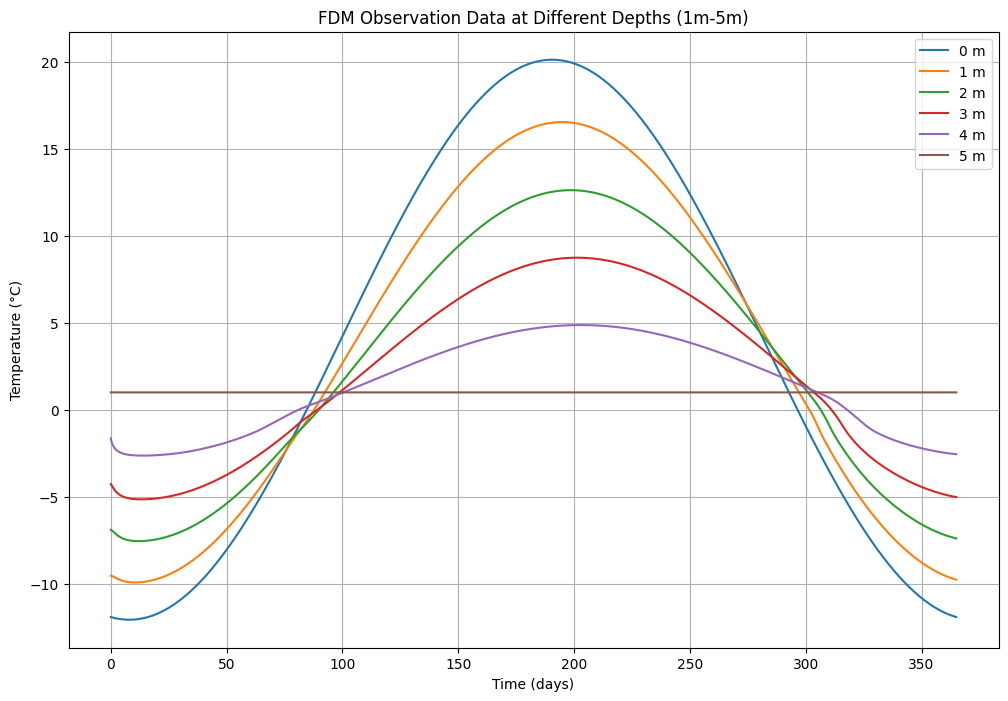


数据前5行:
   time_days  temperature_0m  temperature_1m  temperature_2m  temperature_3m  \
0    0.00000      -11.926392       -9.552234       -6.914287       -4.276604   
1    0.00365      -11.926532       -9.552312       -6.914457       -4.277133   
2    0.00730      -11.926671       -9.552390       -6.914628       -4.277667   
3    0.01095      -11.926810       -9.552468       -6.914799       -4.278204   
4    0.01460      -11.926949       -9.552546       -6.914971       -4.278746   

   temperature_4m  temperature_5m  
0       -1.641872             1.0  
1       -1.645727             1.0  
2       -1.649533             1.0  
3       -1.653264             1.0  
4       -1.656913             1.0  

数据统计信息:
           time_days  temperature_0m  temperature_1m  temperature_2m  \
count  100000.000000   100000.000000   100000.000000   100000.000000   
mean      182.500000        4.030000        3.370696        2.655721   
std       105.368005       11.391547        9.369297        7.147992  

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def save_existing_fdm_data_to_csv(T_field, T_total, Nt, filename='fdm_observation_data.csv'):
    """
    Save existing FDM data to CSV format.
    The first column is time, and the following five columns represent the temperature fields
    at depths of 1m, 2m, 3m, 4m, and 5m.
    
    Parameters:
    T_field: temperature field [space_points, time_points] - your existing data
    T_total: total time (days) - your existing data
    Nt: number of time steps - your existing data
    filename: output filename
    """
    
    # Time array
    time_days = np.linspace(0, T_total, Nt)
    
    # Define depth indices and corresponding actual depths (save only 1m–5m)
    depth_indices = [0, 9, 19, 29, 39, 49]  # indices corresponding to 1m–5m depths
    actual_depths = [0, 1, 2, 3, 4, 5]      # actual depth values (meters)
    
    # Create a data dictionary
    data_dict = {'time_days': time_days}
    
    # Add temperature data for each depth (save only 1m–5m)
    for idx, depth_idx in enumerate(depth_indices):
        column_name = f'temperature_{actual_depths[idx]}m'
        data_dict[column_name] = T_field[depth_idx, :]
    
    # Create DataFrame
    df = pd.DataFrame(data_dict)
    
    # Save as CSV
    df.to_csv(filename, index=False)
    
    print(f"FDM data saved to {filename}")
    print(f"Number of time points: {len(time_days)}")
    print(f"Saved depths: {actual_depths}m")
    print(f"Data shape: {df.shape}")
    print("\nColumn names:")
    for col in df.columns:
        print(f"  - {col}")
    
    # Plot the saved data for verification
    plt.figure(figsize=(12, 8))
    for depth in actual_depths:
        plt.plot(df['time_days'], df[f'temperature_{depth}m'], label=f'{depth} m')
    
    plt.xlabel('Time (days)')
    plt.ylabel('Temperature (°C)')
    plt.title('FDM Observation Data at Different Depths (1m-5m)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Show the first few rows of data
    print("\nFirst 5 rows of data:")
    print(df.head())
    
    # Show data statistics
    print("\nStatistical summary:")
    print(df.describe())
    
    return df

# Directly call the function to save data
# Ensure you already have the following variables:
# T_field, T_total, Nt

# Call the saving function
df = save_existing_fdm_data_to_csv(T_field, T_total, Nt, 'fdm_observation_data.csv')


## PINNs Forward Modeling

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Neural network definition
class PhaseChangePINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f'linear_{i}', nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.net.add_module(f'tanh_{i}', nn.Tanh())
        # Parameter initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# PINNs solver class
class FreezingSoilPINN:
    def __init__(self, params, device='cuda'):
        # Physical parameters
        self.device = device
        self.L = torch.tensor(params['L'], device=device)
        self.C_i = torch.tensor(params['C_i'], device=device)
        self.C_l = torch.tensor(params['C_l'], device=device)
        self.C_f = torch.tensor(params['C_f'], device=device)
        self.lambda_i = torch.tensor(params['lambda_i'], device=device)
        self.lambda_l = torch.tensor(params['lambda_l'], device=device)
        self.lambda_f = torch.tensor(params['lambda_f'], device=device)
        self.eta = torch.tensor(params['eta'], device=device)
        self.b = torch.tensor(params['b'], device=device)
        self.T_nabla = torch.tensor(params['T_nabla'], device=device)
        
        # Neural network
        self.model = PhaseChangePINN([2, 50, 50, 50, 1]).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        # self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=500, factor=0.5)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=1000)
        
        # Loss logs
        self.loss_history = []
        self.pde_loss = []
        self.bc0_loss = []
        self.bcL_loss = []
        self.ic_loss = []

    def _pore_water(self, T):
        """Pore water content calculation"""
        return torch.where(T >= self.T_nabla,
                          torch.ones_like(T),
                          torch.abs(self.T_nabla)**self.b * torch.abs(T)**(-self.b))

    def _unfrozen_water(self, T):
        """Unfrozen water content calculation"""
        return self.eta * self._pore_water(T)

    def _effective_heat_capacity(self, T):
        """Effective heat capacity calculation"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.C_f + self.eta*(phi*self.C_l + (1-phi)*self.C_i)

    def _effective_conductivity(self, T):
        """Effective thermal conductivity calculation"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.lambda_f + self.eta*(phi*self.lambda_l + (1-phi)*self.lambda_i)

    def _boundary_temp(self, t):
        """Upper boundary temperature function (x=0)"""
        return 4.03 + 16.11*torch.sin(2*np.pi*t/365 - 1.709)

    def _initial_temp(self, x):
        """Initial temperature field (t=0), linear interpolation"""
        z1, z2 = 0.0, 5.0 
        T1 = self._boundary_temp(torch.tensor(0.0)).item()  # Upper boundary temperature at t=0
        T2 = 1.0  # Lower boundary temperature
        return T1 + (T2 - T1)/(z2 - z1) * x


    def compute_loss(self, x, t):
        # Forward pass
        T_pred = self.model(torch.cat([x, t], dim=1))
        
        # Compute gradients
        dT_dt = torch.autograd.grad(T_pred, t, grad_outputs=torch.ones_like(T_pred), 
                                   create_graph=True, retain_graph=True)[0]
        dT_dx = torch.autograd.grad(T_pred, x, grad_outputs=torch.ones_like(T_pred),
                                   create_graph=True, retain_graph=True)[0]
        d2T_dx2 = torch.autograd.grad(dT_dx, x, grad_outputs=torch.ones_like(dT_dx),
                                     create_graph=True, retain_graph=True)[0]
        
        # Material property calculations
        C_eff = self._effective_heat_capacity(T_pred)
        lambda_eff = self._effective_conductivity(T_pred)
        theta = self._unfrozen_water(T_pred)
        dtheta_dt = torch.autograd.grad(theta, t, grad_outputs=torch.ones_like(theta),
                                       create_graph=True, retain_graph=True)[0]
        
        # PDE residual
        pde_res = C_eff*dT_dt - lambda_eff*d2T_dx2 - self.L*dtheta_dt
        pde_loss = torch.mean(pde_res**2)
        
        # Upper boundary condition (x=0)
        bc0_mask = (x == 0).squeeze()
        bc0_pred = T_pred[bc0_mask]
        bc0_true = self._boundary_temp(t[bc0_mask]) / self.T_max  # Scaled boundary condition
        bc0_loss = torch.mean((bc0_pred - bc0_true)**2)
        
        # Lower boundary condition (x=5)
        bcL_mask = (x == 5).squeeze()
        bcL_pred = T_pred[bcL_mask]
        bcL_true = torch.ones_like(bcL_pred) / self.T_max  # Scaled boundary condition
        bcL_loss = torch.mean((bcL_pred - bcL_true)**2)
        
        # Initial condition (t=0)
        ic_mask = (t == 0).squeeze()
        ic_pred = T_pred[ic_mask]
        ic_true = self._initial_temp(x[ic_mask]).unsqueeze(1) / self.T_max  # Scaled initial condition
        ic_loss = torch.mean((ic_pred - ic_true)**2)
        
        # Return total loss and component losses
        return 1e2*(pde_loss + bc0_loss + bcL_loss) + 1*ic_loss, pde_loss, bc0_loss, bcL_loss, ic_loss

    def train(self, x_domain, t_domain, epochs=20000, n_samples=10000):
        # Compute T_max (max of x=0 boundary data)
        t_test = torch.linspace(t_domain[0], t_domain[1], 1000, device=self.device)
        self.T_max = torch.max(self._boundary_temp(t_test)).item()
        print(f"T_max (scaling factor): {self.T_max}")
        
        # Generate training data
        x = torch.rand(n_samples, 1, device=self.device)*(x_domain[1]-x_domain[0]) + x_domain[0]
        t = torch.rand(n_samples, 1, device=self.device)*(t_domain[1]-t_domain[0]) + t_domain[0]
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        # Add boundary points (enforced sampling)
        bc0_points = torch.zeros(500, 1, device=self.device)
        bc0_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        bcL_points = torch.ones(500, 1, device=self.device)*5.0
        bcL_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        ic_points = torch.rand(1000, 1, device=self.device) * 5.0  # Increased to 2000 points
        ic_times = torch.zeros(1000, 1, device=self.device)
        
        x = torch.cat([x, bc0_points, bcL_points, ic_points])
        t = torch.cat([t, bc0_times, bcL_times, ic_times])
    
            # Training loop
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            
            # Compute loss
            total_loss, pde_loss, bc0_loss, bcL_loss, ic_loss = self.compute_loss(x, t)
            
            # Dynamically adjust IC weight
            if epoch < 10000:  # First 10000 epochs: focus on IC
                ic_weight = 1
            # elif epoch < 15000:  # Middle phase: gradually reduce IC weight
            #     ic_weight = 1e1
            else:  # Later phase: normal weight
                ic_weight = 1e3
                
            # Apply dynamic weight
            weighted_loss = 1e2*(pde_loss + bc0_loss + bcL_loss) + ic_weight*ic_loss
            weighted_loss.backward()
            
            self.optimizer.step()
            self.scheduler.step()
            
            # Log losses (using original values)
            self.loss_history.append(total_loss.item())
            self.pde_loss.append(pde_loss.item())
            self.bc0_loss.append(bc0_loss.item())
            self.bcL_loss.append(bcL_loss.item())
            self.ic_loss.append(ic_loss.item())
            
            # Print losses (using original values)
            if epoch % 1000 == 0:
                print(f'Epoch {epoch:5d}, Loss: {total_loss.item():.3e} | '
                      f'PDE: {pde_loss.item():.3e} | BC0: {bc0_loss.item():.3e} | '
                      f'BCL: {bcL_loss.item():.3e} | IC: {ic_loss.item():.3e}')
                
        return self.loss_history


    
    def predict(self, x, t):
        with torch.no_grad():
            xt = torch.cat([x, t], dim=1)
            return self.model(xt)

# Parameter configuration
params = {
    'L': 3.34e5,        # Latent heat of phase change (KJ/m³)
    'C_i': 1.672,       # Heat capacity of ice (KJ/(m³·K))
    'C_l': 4.18,        # Heat capacity of water (KJ/(m³·K))
    'C_f': 1.5,         # Heat capacity of soil matrix
    'lambda_i': 2.210,  # Thermal conductivity of ice (W/(m·K))
    'lambda_l': 0.465,  # Thermal conductivity of water
    'lambda_f': 1.5,    # Thermal conductivity of soil matrix
    'eta': 0.4,         # Porosity
    'b': 1.5,           # Unfrozen water parameter
    'T_nabla': -1.0     # Freezing temperature (°C)
}

# Training parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_domain = (0.0, 5.0)   # Spatial domain (m)
# t_domain = (0.0, 365.0) # Time domain (days)
t_domain = (-1.0, 365.0) # Time domain (days)
# t_domain = (0.0, 180.0) # Time domain (days)
epochs = 100000
# epochs = 50000

# Initialize and train the model
pinn = FreezingSoilPINN(params, device)
loss_history = pinn.train(x_domain, t_domain, epochs=epochs)

# Results visualization
def plot_results():
    x_test = torch.linspace(0, 5, 50, device=device).unsqueeze(1)
    t_test = torch.linspace(0, 365, 1e6, device=device).unsqueeze(1)
    X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze())
    
    with torch.no_grad():
        inputs = torch.stack([X.ravel(), T.ravel()], dim=1)
        T_pred = pinn.predict(inputs[:,0:1], inputs[:,1:2]).cpu().numpy()

T_max (scaling factor): 20.139986038208008
Epoch     0, Loss: 4.832e+01 | PDE: 1.974e-03 | BC0: 4.507e-01 | BCL: 3.009e-02 | IC: 4.419e-02
Epoch  1000, Loss: 1.198e+01 | PDE: 1.594e-03 | BC0: 1.144e-01 | BCL: 3.353e-03 | IC: 4.994e-02
Epoch  2000, Loss: 2.698e+00 | PDE: 2.276e-03 | BC0: 2.166e-02 | BCL: 2.339e-03 | IC: 7.037e-02
Epoch  3000, Loss: 9.161e-01 | PDE: 2.904e-03 | BC0: 5.098e-03 | BCL: 5.845e-04 | IC: 5.752e-02
Epoch  4000, Loss: 6.145e-01 | PDE: 2.473e-03 | BC0: 2.941e-03 | BCL: 2.151e-04 | IC: 5.161e-02
Epoch  5000, Loss: 5.077e-01 | PDE: 2.033e-03 | BC0: 2.446e-03 | BCL: 1.194e-04 | IC: 4.789e-02
Epoch  6000, Loss: 4.434e-01 | PDE: 1.680e-03 | BC0: 2.229e-03 | BCL: 7.608e-05 | IC: 4.492e-02
Epoch  7000, Loss: 4.024e-01 | PDE: 1.446e-03 | BC0: 2.094e-03 | BCL: 5.249e-05 | IC: 4.311e-02
Epoch  8000, Loss: 3.690e-01 | PDE: 1.245e-03 | BC0: 1.985e-03 | BCL: 4.312e-05 | IC: 4.177e-02
Epoch  9000, Loss: 3.442e-01 | PDE: 1.106e-03 | BC0: 1.893e-03 | BCL: 3.331e-05 | IC: 4.100e-

/environment/miniconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


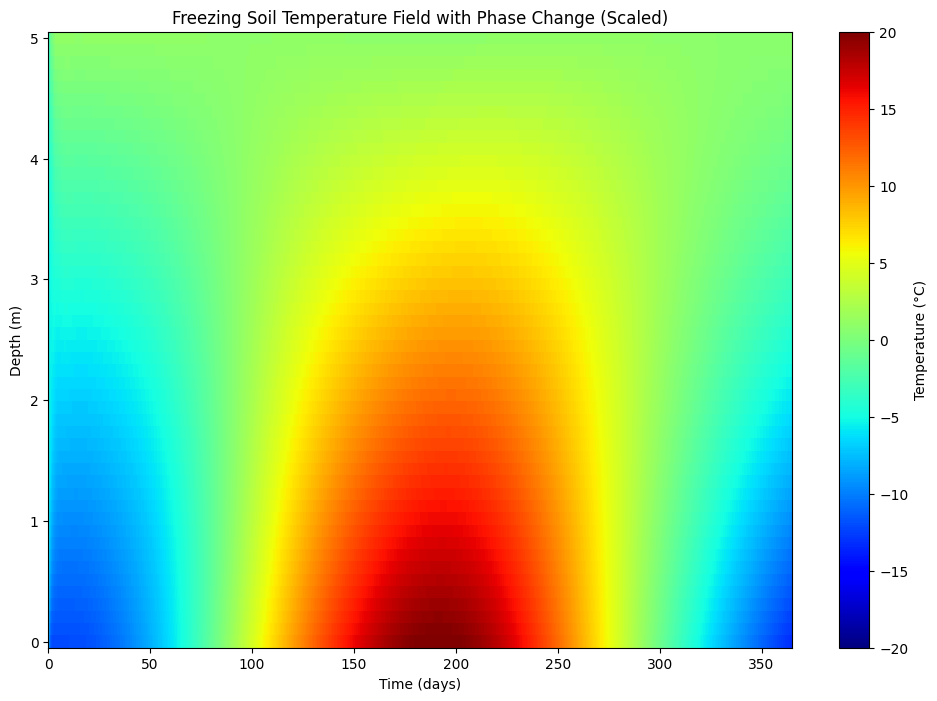

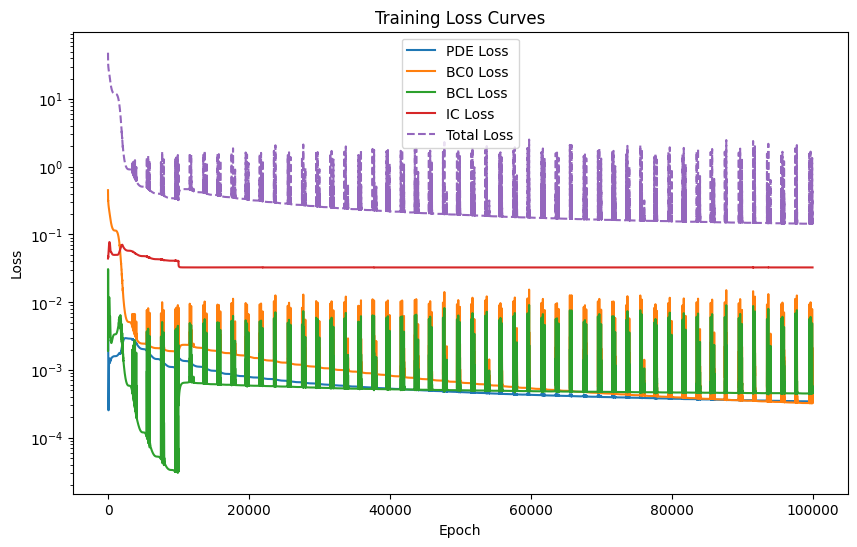

In [10]:
# Results visualization
def plot_results():
    x_test = torch.linspace(0, 5, 50, device=device).unsqueeze(1)
    t_test = torch.linspace(0, 365, 10000, device=device).unsqueeze(1)
    X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze())
    
    with torch.no_grad():
        inputs = torch.stack([X.ravel(), T.ravel()], dim=1)
        T_pred = pinn.predict(inputs[:,0:1], inputs[:,1:2]).cpu().numpy()
    
    # Scale back to the original range
    T_pred_scaled = T_pred * pinn.T_max
    
    plt.figure(figsize=(12,8))
    plt.pcolormesh(T.cpu().numpy(), X.cpu().numpy(), T_pred_scaled.reshape(50,10000), 
                   cmap='jet', shading='auto', vmin=-20, vmax=20)
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Time (days)')
    plt.ylabel('Depth (m)')
    plt.title('Freezing Soil Temperature Field with Phase Change (Scaled)')
    
    # Add isotherms
    # levels = np.linspace(-20, 20, 15)
    # CS = plt.contour(T.cpu().numpy(), X.cpu().numpy(), T_pred_scaled.reshape(100,100), 
    #                 levels=levels, colors='k', linewidths=0.5)
    # plt.clabel(CS, inline=True, fontsize=8)
    
    plt.show()

plot_results()

# Plot loss curves
def plot_loss_curves():
    plt.figure(figsize=(10,6))
    plt.semilogy(pinn.pde_loss, label='PDE Loss')
    plt.semilogy(pinn.bc0_loss, label='BC0 Loss')
    plt.semilogy(pinn.bcL_loss, label='BCL Loss')
    plt.semilogy(pinn.ic_loss, label='IC Loss')
    plt.semilogy(pinn.loss_history, label='Total Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Curves')
    plt.show()

plot_loss_curves()

最大绝对误差: 6.4264 °C
平均绝对误差: 0.4681 °C
最大相对误差: 5753307.61%
平均相对误差: 62.55%


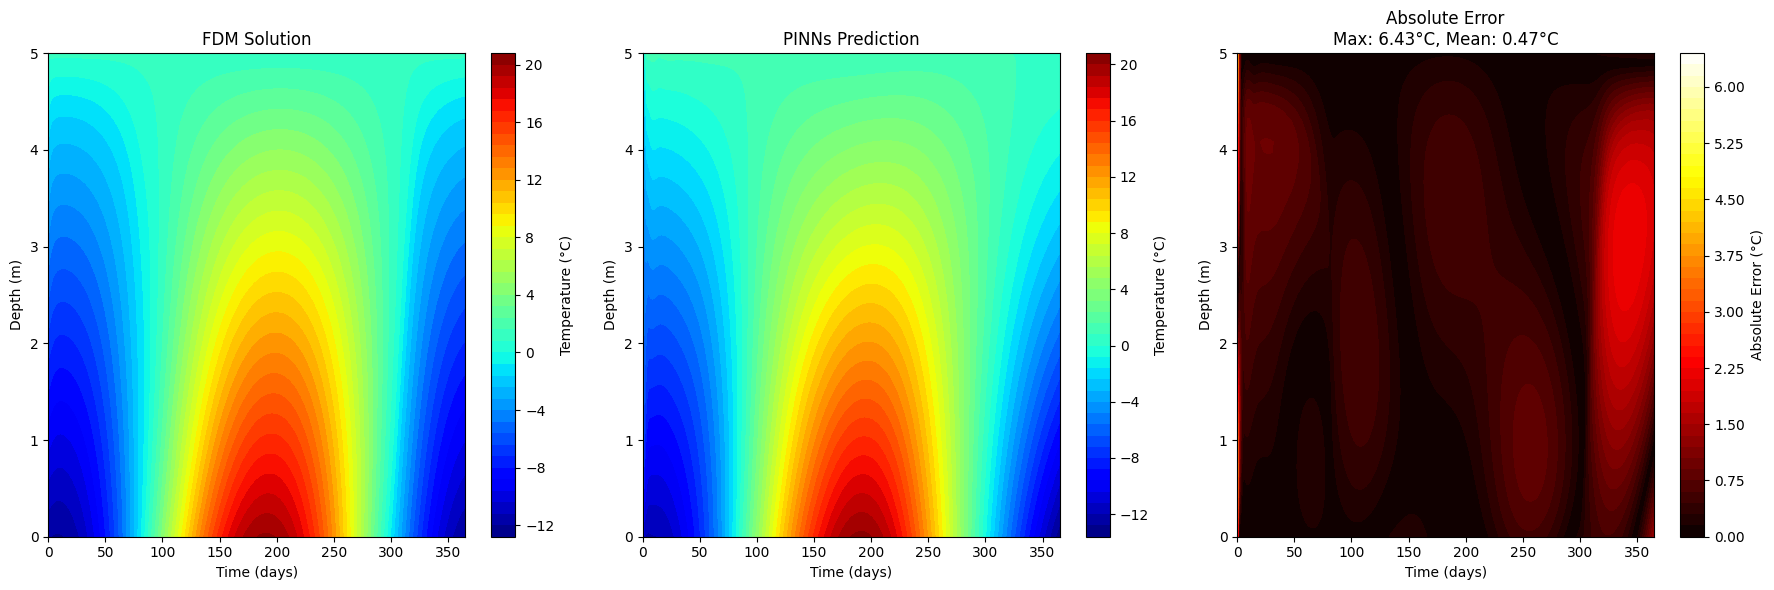

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ===================================================
# FDM results
# ===================================================
# Assume the FDM results have already been computed
T_total = 365.0  # Total time (days)
Nx = 50          # Number of spatial points
Nt = 100000      # Number of time steps
x_fdm = x  # Spatial grid (0 to 5 meters)
t_fdm = np.linspace(0, T_total, Nt)  # Time grid (0 to 365 days)
T_field_fdm = T_field  # FDM computation result (array of shape Nx x Nt)

# ===================================================
# PINNs prediction
# ===================================================
# Assume the PINNs model has been trained and can predict temperature for any (x, t)
def pinn_predict(x, t):
    """PINNs prediction function, replace with your actual prediction code"""
    # Example code (to be replaced):
    inputs = torch.tensor(np.stack([x, t], axis=1), dtype=torch.float32).to(device)
    with torch.no_grad():
        return pinn.model(inputs).cpu().numpy().flatten()

# Predict on the FDM grid points
X_fdm, T_fdm = np.meshgrid(x_fdm, t_fdm)  # Generate grid points
T_field_pinn = np.zeros_like(T_field_fdm)  # Initialize PINNs prediction result

# Batch prediction (improves efficiency)
inputs = torch.tensor(np.stack([X_fdm.ravel(), T_fdm.ravel()], axis=1), dtype=torch.float32).to(device)
with torch.no_grad():
    T_field_pinn = pinn.model(inputs).cpu().numpy().reshape(X_fdm.shape).T * pinn.T_max  # Transpose to match FDM shape

# ===================================================
# Error analysis
# ===================================================
# Compute absolute and relative errors
abs_error = np.abs(T_field_pinn - T_field_fdm)
rel_error = abs_error / (np.abs(T_field_fdm) + 1e-6)  # Avoid division by zero

# Statistics
max_abs_error = np.max(abs_error)
mean_abs_error = np.mean(abs_error)
max_rel_error = np.max(rel_error)
mean_rel_error = np.mean(rel_error)

print(f"Maximum absolute error: {max_abs_error:.4f} °C")
print(f"Mean absolute error: {mean_abs_error:.4f} °C")
print(f"Maximum relative error: {max_rel_error*100:.2f}%")
print(f"Mean relative error: {mean_rel_error*100:.2f}%")

# ===================================================
# Visualization comparison
# ===================================================
plt.figure(figsize=(18, 6))

# FDM result
plt.subplot(1, 3, 1)
plt.contourf(t_fdm, x_fdm, T_field_fdm, levels=50, cmap='jet')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Time (days)')
plt.ylabel('Depth (m)')
plt.title('FDM Solution')

# PINNs result
plt.subplot(1, 3, 2)
plt.contourf(t_fdm, x_fdm, T_field_pinn, levels=50, cmap='jet')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Time (days)')
plt.ylabel('Depth (m)')
plt.title('PINNs Prediction')

# Absolute error
plt.subplot(1, 3, 3)
error_plot = plt.contourf(t_fdm, x_fdm, abs_error, levels=50, cmap='hot')
plt.colorbar(error_plot, label='Absolute Error (°C)')
plt.xlabel('Time (days)')
plt.ylabel('Depth (m)')
plt.title(f'Absolute Error\nMax: {max_abs_error:.2f}°C, Mean: {mean_abs_error:.2f}°C')

plt.tight_layout()
plt.show()


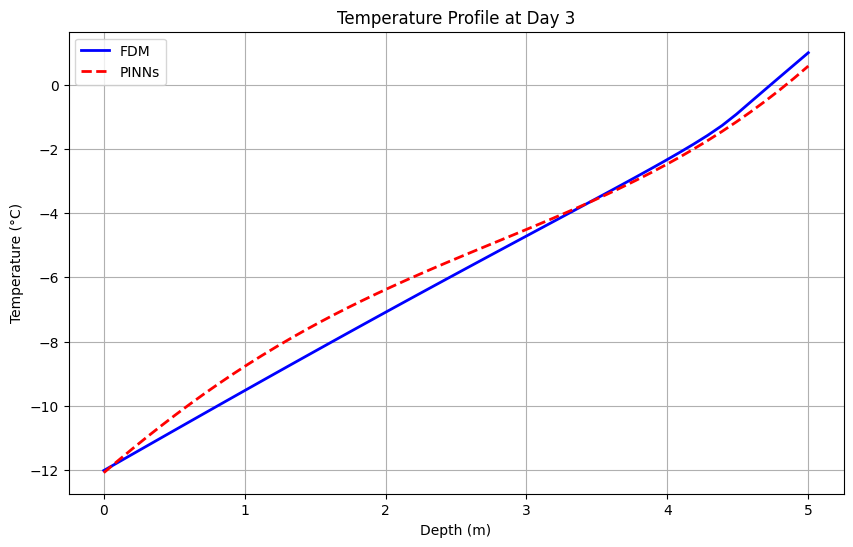

In [12]:
# ===================================================
# Time-slice comparison (example: Day 0)
# ===================================================
day = 3
t_index = int(day / T_total * Nt) - 1

plt.figure(figsize=(10, 6))
plt.plot(x_fdm, T_field_fdm[:, t_index], 'b-', linewidth=2, label='FDM')
plt.plot(x_fdm, T_field_pinn[:, t_index], 'r--', linewidth=2, label='PINNs')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Profile at Day {day}')
plt.legend()
plt.grid(True)
plt.show()


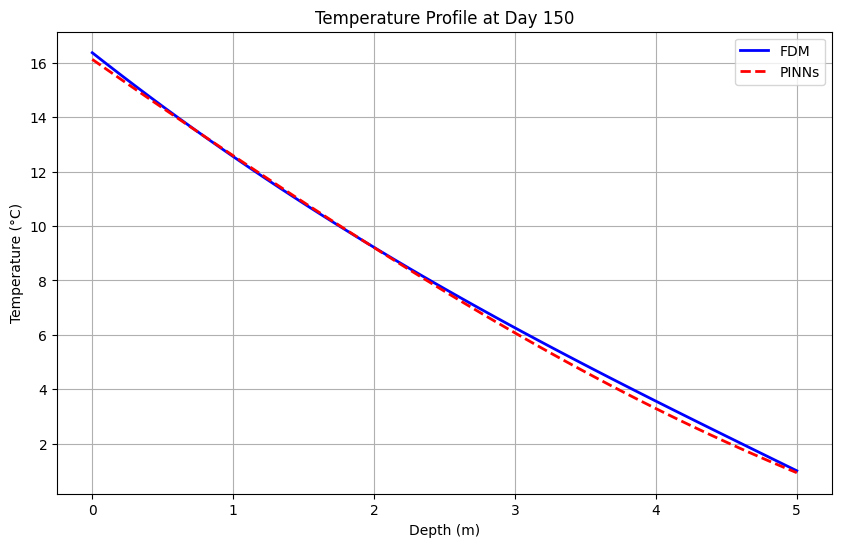

In [13]:
# ===================================================
# Time-slice comparison (example: Day 150)
# ===================================================
day = 150
t_index = int(day / T_total * Nt)

plt.figure(figsize=(10, 6))
plt.plot(x_fdm, T_field_fdm[:, t_index], 'b-', linewidth=2, label='FDM')
plt.plot(x_fdm, T_field_pinn[:, t_index], 'r--', linewidth=2, label='PINNs')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Profile at Day {day}')
plt.legend()
plt.grid(True)
plt.show()

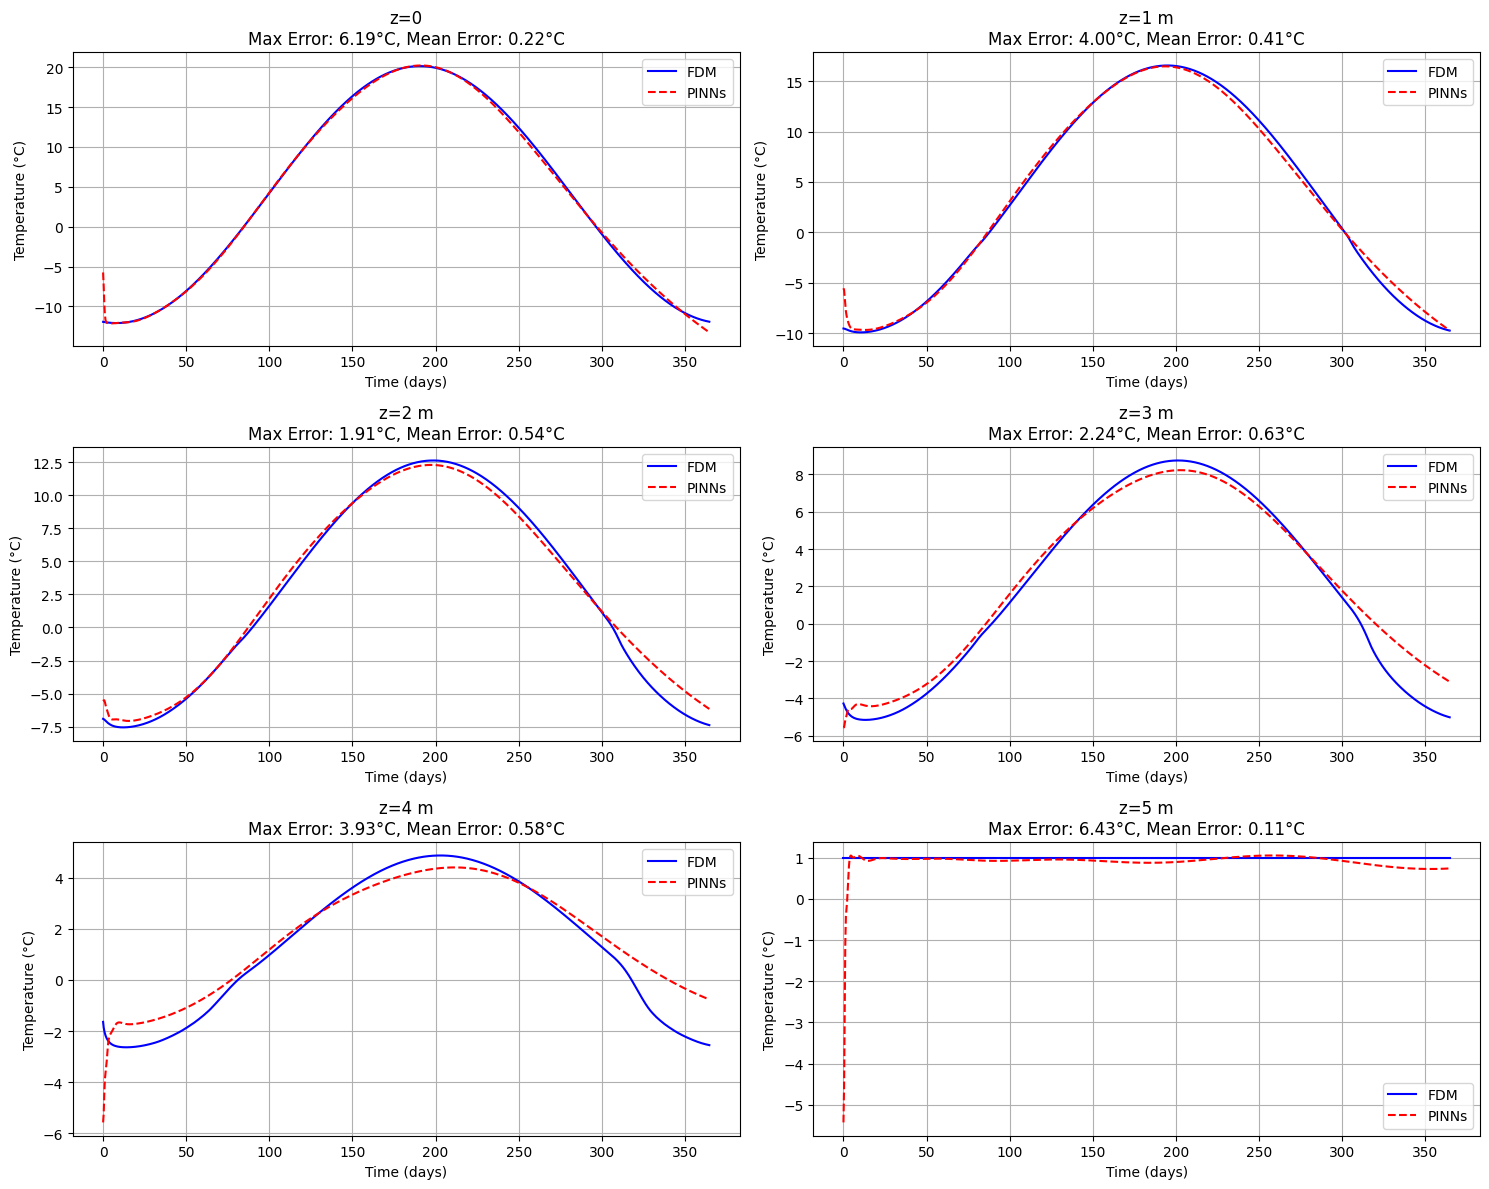

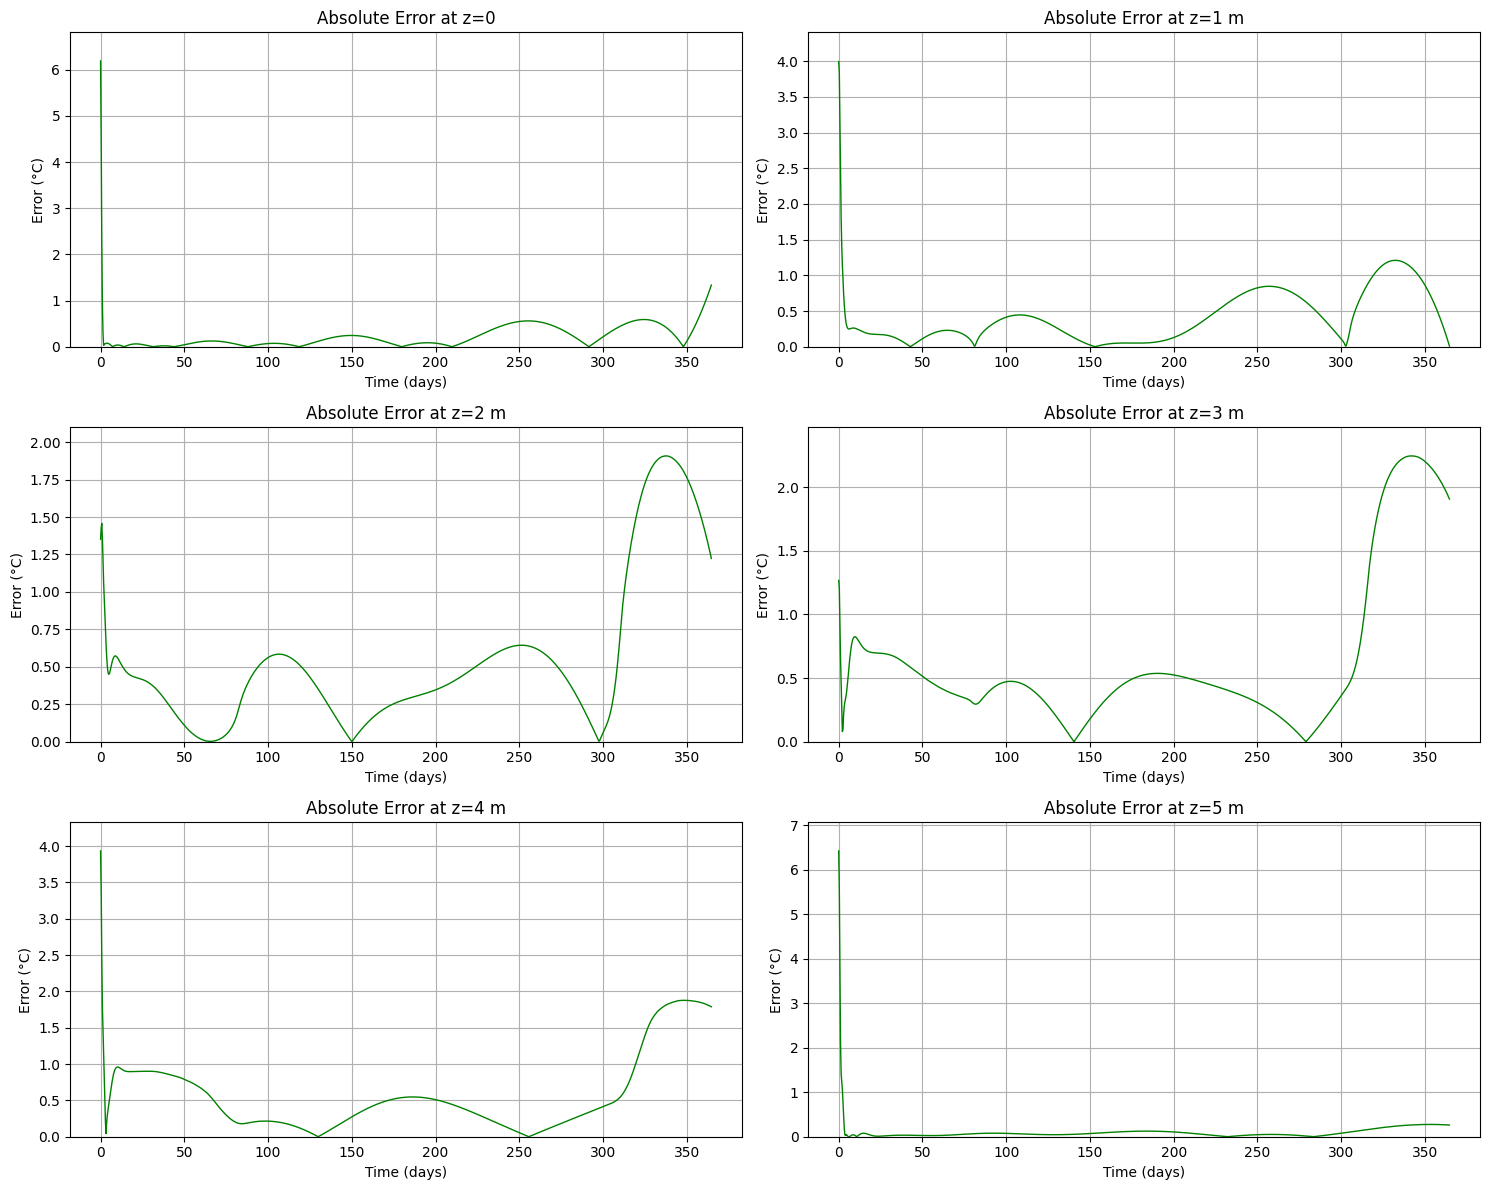

深度位置 | 最大绝对误差 (°C) | 平均绝对误差 (°C)
z=0    | 6.1910           | 0.2212          
z=1 m  | 4.0047           | 0.4066          
z=2 m  | 1.9080           | 0.5436          
z=3 m  | 2.2445           | 0.6280          
z=4 m  | 3.9344           | 0.5745          
z=5 m  | 6.4264           | 0.1037          


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ===================================================
# Parameter settings
# ===================================================
depths = [0, 9, 19, 29, 39, 49]  # Indices corresponding to depths z=0,1,2,3,4,5 meters
depth_labels = ['z=0', 'z=1 m', 'z=2 m', 'z=3 m', 'z=4 m', 'z=5 m']

# ===================================================
# Load FDM results
# ===================================================


# ===================================================
# Visualization comparison
# ===================================================
plt.figure(figsize=(15, 12))

# Loop through each depth to plot comparisons
for idx, depth_idx in enumerate(depths):
    # Extract data
    t_plot = t_fdm[::100]  # Downsample: take one point every 100 steps
    fdm_vals = T_field_fdm[depth_idx, ::100]
    pinn_vals = T_field_pinn[depth_idx, ::100]
    
    # Create subplot
    plt.subplot(3, 2, idx+1)
    
    # Plot curves
    plt.plot(t_plot, fdm_vals, 'b-', linewidth=1.5, label='FDM')
    plt.plot(t_plot, pinn_vals, 'r--', linewidth=1.5, label='PINNs')
    
    # Compute errors
    abs_error = np.abs(pinn_vals - fdm_vals)
    max_error = np.max(abs_error)
    mean_error = np.mean(abs_error)
    
    # Add annotation
    plt.title(f'{depth_labels[idx]}\nMax Error: {max_error:.2f}°C, Mean Error: {mean_error:.2f}°C')
    plt.xlabel('Time (days)')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# ===================================================
# Error analysis (over the entire time domain)
# ===================================================
plt.figure(figsize=(15, 12))

for idx, depth_idx in enumerate(depths):
    # Compute absolute error
    abs_error = np.abs(T_field_pinn[depth_idx, :] - T_field_fdm[depth_idx, :])
    
    # Create subplot
    plt.subplot(3, 2, idx+1)
    
    # Plot error curve
    plt.plot(t_fdm[::100], abs_error[::100], 'g-', linewidth=1)
    plt.title(f'Absolute Error at {depth_labels[idx]}')
    plt.xlabel('Time (days)')
    plt.ylabel('Error (°C)')
    plt.grid(True)
    plt.ylim(0, np.max(abs_error)*1.1)

plt.tight_layout()
plt.show()

# ===================================================
# Statistical metrics output
# ===================================================
print("="*50)
print("Depth | Max Absolute Error (°C) | Mean Absolute Error (°C)")
print("="*50)
for idx, depth_idx in enumerate(depths):
    abs_error = np.abs(T_field_pinn[depth_idx, :] - T_field_fdm[depth_idx, :])
    print(f"{depth_labels[idx]:<6} | {np.max(abs_error):<24.4f} | {np.mean(abs_error):<24.4f}")
print("="*50)

# PINNs Inversion

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.interpolate import interp1d

# 设定随机种子保证可重复性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# 神经网络定义
class PhaseChangePINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f'linear_{i}', nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.net.add_module(f'tanh_{i}', nn.Tanh())
        # 参数初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

class InversionFreezingSoilPINN:
    def __init__(self, known_params, param_bounds, device='cuda'):
        self.device = device
        
        # 已知固定参数
        self.L = torch.tensor(known_params['L'], device=device)
        self.C_i = torch.tensor(known_params['C_i'], device=device)
        self.C_l = torch.tensor(known_params['C_l'], device=device)
        self.lambda_i = torch.tensor(known_params['lambda_i'], device=device)
        self.lambda_l = torch.tensor(known_params['lambda_l'], device=device)
        
        # 待估参数 - 初始化为边界中间值并设为可训练参数
        self.param_bounds = param_bounds
        self.param_names = list(param_bounds.keys())
        
        # 使用参数范围的中间值初始化
        self.lambda_f = nn.Parameter(torch.tensor(
            (param_bounds['lambda_f'][0] + param_bounds['lambda_f'][1]) / 2, device=device))
        self.C_f = nn.Parameter(torch.tensor(
            (param_bounds['C_f'][0] + param_bounds['C_f'][1]) / 2, device=device))
        self.eta = nn.Parameter(torch.tensor(
            (param_bounds['eta'][0] + param_bounds['eta'][1]) / 2, device=device))
        self.b = nn.Parameter(torch.tensor(
            (param_bounds['b'][0] + param_bounds['b'][1]) / 2, device=device))
        self.T_nabla = nn.Parameter(torch.tensor(
            (param_bounds['T_nabla'][0] + param_bounds['T_nabla'][1]) / 2, device=device))
        
        # 参数约束
        self.param_constraints = {}
        for param_name, (min_val, max_val) in param_bounds.items():
            self.param_constraints[param_name] = (min_val, max_val)
        
        # 神经网络（与正演PINNs相同的结构）
        self.model = PhaseChangePINN([2, 50, 50, 50, 1]).to(device)
        
        # 优化器需要同时优化神经网络参数和物理参数
        self.optimizer = optim.Adam([
            {'params': self.model.parameters(), 'lr': 1e-4},
            {'params': [self.lambda_f, self.C_f, self.eta, self.b, self.T_nabla], 'lr': 1e-3}
        ])
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=1000)
        
        # 损失记录
        self.loss_history = []
        self.pde_loss_history = []
        self.data_loss_history = []
        self.boundary_loss_history = []
        
        # 参数历史记录
        self.param_history = {name: [] for name in self.param_names}
        
        # 存储边界条件数据
        self.boundary_data = None
        self.T_max = 20.0  # 默认值，稍后计算
        self.boundary_interp_func = None  # 边界插值函数

    def apply_param_constraints(self):
        """应用参数约束"""
        with torch.no_grad():
            for param_name, (min_val, max_val) in self.param_constraints.items():
                param = getattr(self, param_name)
                param.data = torch.clamp(param.data, min_val, max_val)

    def get_current_params(self):
        """获取当前参数值"""
        return {
            'lambda_f': self.lambda_f.item(),
            'C_f': self.C_f.item(),
            'eta': self.eta.item(),
            'b': self.b.item(),
            'T_nabla': self.T_nabla.item()
        }

    def _pore_water(self, T):
        """孔隙水含量计算（与正演PINNs相同）"""
        return torch.where(T >= self.T_nabla,
                          torch.ones_like(T),
                          torch.abs(self.T_nabla)**self.b * torch.abs(T)**(-self.b))

    def _unfrozen_water(self, T):
        """未冻水含量计算（与正演PINNs相同）"""
        return self.eta * self._pore_water(T)

    def _effective_heat_capacity(self, T):
        """有效热容计算（与正演PINNs相同）"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.C_f + self.eta*(phi*self.C_l + (1-phi)*self.C_i)

    def _effective_conductivity(self, T):
        """有效导热系数计算（与正演PINNs相同）"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.lambda_f + self.eta*(phi*self.lambda_l + (1-phi)*self.lambda_i)

    def _create_boundary_interp_func(self):
        """创建边界插值函数"""
        if self.boundary_data is not None:
            time_points = self.boundary_data['time_days'].values
            temp_values = self.boundary_data['temperature_0m'].values
            # 创建线性插值函数
            self.boundary_interp_func = interp1d(time_points, temp_values, 
                                                kind='linear', bounds_error=False, 
                                                fill_value="extrapolate")
        else:
            self.boundary_interp_func = None

    def _boundary_temp(self, t):
        """上边界温度函数 (x=0) - 直接从CSV中获取表面温度"""
        # 处理张量输入
        if isinstance(t, torch.Tensor):
            t_np = t.detach().cpu().numpy().flatten()
            
            if self.boundary_interp_func is not None:
                # 使用插值函数
                temp_values = self.boundary_interp_func(t_np)
                return torch.tensor(temp_values / self.T_max, dtype=torch.float32, device=self.device).unsqueeze(1)
            else:
                # 如果没有边界数据，使用默认值
                temp_values = 4.03 + 16.11*np.sin(2*np.pi*t_np/365 - 1.709)
                return torch.tensor(temp_values / self.T_max, dtype=torch.float32, device=self.device).unsqueeze(1)
        else:
            # 标量输入
            t_scalar = t
            
            if self.boundary_interp_func is not None:
                return self.boundary_interp_func(t_scalar) / self.T_max
            else:
                return (4.03 + 16.11*np.sin(2*np.pi*t_scalar/365 - 1.709)) / self.T_max

    def compute_physics_loss(self, x, t):
        """计算物理约束损失（与正演PINNs相同的计算方式）"""
        T_pred = self.model(torch.cat([x, t], dim=1))
        
        # 计算梯度
        dT_dt = torch.autograd.grad(T_pred, t, grad_outputs=torch.ones_like(T_pred), 
                                   create_graph=True, retain_graph=True)[0]
        dT_dx = torch.autograd.grad(T_pred, x, grad_outputs=torch.ones_like(T_pred),
                                   create_graph=True, retain_graph=True)[0]
        d2T_dx2 = torch.autograd.grad(dT_dx, x, grad_outputs=torch.ones_like(dT_dx),
                                     create_graph=True, retain_graph=True)[0]
        
        # 物性参数计算
        C_eff = self._effective_heat_capacity(T_pred)
        lambda_eff = self._effective_conductivity(T_pred)
        theta = self._unfrozen_water(T_pred)
        dtheta_dt = torch.autograd.grad(theta, t, grad_outputs=torch.ones_like(theta),
                                       create_graph=True, retain_graph=True)[0]
        
        # PDE残差（与正演PINNs相同）
        pde_res = C_eff*dT_dt - lambda_eff*d2T_dx2 - self.L*dtheta_dt
        pde_loss = torch.mean(pde_res**2)
        
        return pde_loss

    def compute_data_loss(self, x_obs, t_obs, T_obs_true):
        """计算观测数据损失"""
        T_pred = self.model(torch.cat([x_obs, t_obs], dim=1))
        data_loss = torch.mean((T_pred - T_obs_true)**2)
        return data_loss

    def compute_boundary_loss(self, x, t):
        """计算边界条件损失"""
        T_pred = self.model(torch.cat([x, t], dim=1))
        
        # 上边界条件 (x=0)
        bc0_mask = (x == 0).squeeze()
        bc0_loss = torch.tensor(0.0, device=self.device)
        if bc0_mask.any():
            bc0_pred = T_pred[bc0_mask]
            bc0_true = self._boundary_temp(t[bc0_mask])
            bc0_loss = torch.mean((bc0_pred - bc0_true)**2)
        
        # 下边界条件 (x=5)
        bcL_mask = (x == 5).squeeze()
        bcL_loss = torch.tensor(0.0, device=self.device)
        if bcL_mask.any():
            bcL_pred = T_pred[bcL_mask]
            bcL_true = torch.ones_like(bcL_pred) * (1.0 / self.T_max)  # 下边界温度1°C，归一化
            bcL_loss = torch.mean((bcL_pred - bcL_true)**2)
        
        return bc0_loss + bcL_loss

    def train(self, x_domain, t_domain, x_obs, t_obs, T_obs_true, epochs=30000):
        print("开始反演训练...")
        print(f"初始参数: {self.get_current_params()}")
        
        # 计算 T_max - 直接从CSV数据中获取最大值
        if self.boundary_data is not None:
            # 计算所有深度温度的最大值
            temp_columns = [col for col in self.boundary_data.columns if col.startswith('temperature_')]
            self.T_max = self.boundary_data[temp_columns].max().max()
            # 创建边界插值函数
            self._create_boundary_interp_func()
        else:
            # 如果没有边界数据，使用默认边界函数的最大值
            t_test = np.linspace(t_domain[0], t_domain[1], 1000)
            boundary_temps = [4.03 + 16.11*np.sin(2*np.pi*t_val/365 - 1.709) for t_val in t_test]
            self.T_max = max(boundary_temps)
        
        print(f"T_max (scaling factor): {self.T_max}")
        
        # 生成训练数据点（与正演PINNs相同的采样策略）
        n_samples = 10000
        x = torch.rand(n_samples, 1, device=self.device) * (x_domain[1] - x_domain[0]) + x_domain[0]
        t = torch.rand(n_samples, 1, device=self.device) * (t_domain[1] - t_domain[0]) + t_domain[0]
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        # 添加边界点强制采样
        bc0_points = torch.zeros(500, 1, device=self.device)
        bc0_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        bcL_points = torch.ones(500, 1, device=self.device)*5.0
        bcL_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        
        x = torch.cat([x, bc0_points, bcL_points])
        t = torch.cat([t, bc0_times, bcL_times])
        
        # 训练循环
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            
            # 计算各项损失
            physics_loss = self.compute_physics_loss(x, t)
            data_loss = self.compute_data_loss(x_obs, t_obs, T_obs_true)
            boundary_loss = self.compute_boundary_loss(x, t)
            
            # 调整损失权重，给数据损失更高权重
            total_loss = (1e2 * physics_loss + 
                        1e2 * boundary_loss + 
                        1e4 * data_loss)  # 数据损失权重最大
            
            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            # 应用参数约束
            self.apply_param_constraints()
            
            # 记录损失和参数
            self.loss_history.append(total_loss.item())
            self.pde_loss_history.append(physics_loss.item())
            self.data_loss_history.append(data_loss.item())
            self.boundary_loss_history.append(boundary_loss.item())
            
            current_params = self.get_current_params()
            for name in self.param_names:
                self.param_history[name].append(current_params[name])
            
            # 打印进度
            if epoch % 1000 == 0:
                print(f'Epoch {epoch:5d}, Total Loss: {total_loss.item():.3e}')
                print(f'  Physics: {physics_loss.item():.3e}, Data: {data_loss.item():.3e}, Boundary: {boundary_loss.item():.3e}')
                print(f'  Current params: {current_params}')
                
        return self.loss_history

    def predict(self, x, t):
        with torch.no_grad():
            xt = torch.cat([x, t], dim=1)
            return self.model(xt) * self.T_max  # 反归一化

def load_fdm_data_from_csv(csv_file='fdm_observation_data.csv'):
    """从CSV文件加载FDM观测数据"""
    df = pd.read_csv(csv_file)
    
    print(f"从 {csv_file} 加载数据成功")
    print(f"数据形状: {df.shape}")
    print(f"列名: {list(df.columns)}")
    
    # 提取时间数据
    t_days = df['time_days'].values
    
    # 提取温度数据
    temperature_data = {}
    obs_depths = []
    
    for col in df.columns:
        if col.startswith('temperature_'):
            # 提取深度值
            depth_str = col.replace('temperature_', '').replace('m', '')
            depth = float(depth_str)
            obs_depths.append(depth)
            temperature_data[depth] = df[col].values
    
    print(f"加载的深度: {sorted(obs_depths)}米")
    print(f"时间点数量: {len(t_days)}")
    print(f"时间范围: {t_days[0]:.1f} 到 {t_days[-1]:.1f} 天")
    
    return df, t_days, temperature_data, obs_depths

def prepare_observation_data_from_csv(csv_file='fdm_observation_data.csv'):
    """从CSV文件准备观测数据用于反演"""
    df, t_days, temperature_data, obs_depths = load_fdm_data_from_csv(csv_file)
    
    # 计算温度最大值用于归一化
    all_temps = np.concatenate([temperature_data[depth] for depth in obs_depths])
    T_max = np.max(all_temps)
    
    # 构建观测数据张量
    x_obs_list = []
    t_obs_list = []
    T_obs_list = []
    
    for depth in obs_depths:
        temp_vals = temperature_data[depth]
        for i, t_val in enumerate(t_days):
            x_obs_list.append([depth])
            t_obs_list.append([t_val])
            T_obs_list.append([temp_vals[i] / T_max])  # 归一化
    
    x_obs = torch.tensor(x_obs_list, dtype=torch.float32)
    t_obs = torch.tensor(t_obs_list, dtype=torch.float32)
    T_obs = torch.tensor(T_obs_list, dtype=torch.float32)
    
    print(f"观测数据形状: x_obs={x_obs.shape}, t_obs={t_obs.shape}, T_obs={T_obs.shape}")
    print(f"归一化后温度范围: {T_obs.min():.4f} 到 {T_obs.max():.4f}")
    
    return df, x_obs, t_obs, T_obs, obs_depths, T_max

def plot_inversion_results(inversion_model, true_params=None):
    """绘制反演结果"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 损失曲线
    ax = axes[0, 0]
    ax.semilogy(inversion_model.loss_history, label='Total Loss')
    ax.semilogy(inversion_model.pde_loss_history, label='Physics Loss')
    ax.semilogy(inversion_model.data_loss_history, label='Data Loss')
    ax.semilogy(inversion_model.boundary_loss_history, label='Boundary Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title('Training Loss')
    ax.grid(True)
    
    # 参数演化
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for idx, param_name in enumerate(inversion_model.param_names):
        ax = axes[(idx+1)//3, (idx+1)%3]
        param_history = inversion_model.param_history[param_name]
        ax.plot(param_history, color=colors[idx], label='Estimated')
        
        # 真实值（如果知道）
        if true_params and param_name in true_params:
            ax.axhline(y=true_params[param_name], color=colors[idx], 
                      linestyle='--', label='True', alpha=0.7)
        
        # 参数范围
        min_val, max_val = inversion_model.param_bounds[param_name]
        ax.axhline(y=min_val, color='gray', linestyle=':', alpha=0.5, label='Bounds')
        ax.axhline(y=max_val, color='gray', linestyle=':', alpha=0.5)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel(param_name)
        ax.legend()
        ax.set_title(f'{param_name} Evolution')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 打印最终参数
    final_params = inversion_model.get_current_params()
    print("\n最终反演参数:")
    for param_name in inversion_model.param_names:
        true_val = true_params.get(param_name, None) if true_params else None
        estimated_val = final_params[param_name]
        if true_val is not None:
            error = abs(estimated_val - true_val) / true_val * 100
            print(f"{param_name}: 估计值={estimated_val:.3f}, 真实值={true_val:.3f}, 误差={error:.1f}%")
        else:
            print(f"{param_name}: {estimated_val:.3f}")

def validate_inversion_results(inversion_model, x_obs, t_obs, T_obs_true, obs_depths, T_max):
    """验证反演结果"""
    print("\n验证反演结果...")
    
    # 使用反演得到的参数进行预测
    with torch.no_grad():
        T_pred = inversion_model.predict(x_obs, t_obs)  # 已经反归一化
    
    # 反归一化真实值
    T_obs_true_denorm = T_obs_true * T_max
    
    # 计算预测误差
    pred_error = torch.abs(T_pred - T_obs_true_denorm)
    mean_error = torch.mean(pred_error).item()
    max_error = torch.max(pred_error).item()
    
    print(f"预测误差 - 平均值: {mean_error:.4f}°C, 最大值: {max_error:.4f}°C")
    
    # 按深度分析误差
    print("\n按深度分析误差:")
    unique_depths = torch.unique(x_obs).cpu().numpy()
    
    for depth in unique_depths:
        depth_mask = (x_obs == depth).squeeze()
        depth_errors = pred_error[depth_mask]
        depth_mean_error = torch.mean(depth_errors).item()
        depth_max_error = torch.max(depth_errors).item()
        print(f"深度 {depth}m - 平均误差: {depth_mean_error:.4f}°C, 最大误差: {depth_max_error:.4f}°C")
    
    # 绘制预测与真实值对比
    plt.figure(figsize=(15, 10))
    
    # 为每个深度创建子图
    for i, depth in enumerate(sorted(unique_depths)):
        depth_mask = (x_obs == depth).squeeze()
        depth_t = t_obs[depth_mask].cpu().numpy()
        depth_T_true = T_obs_true_denorm[depth_mask].cpu().numpy()
        depth_T_pred = T_pred[depth_mask].cpu().numpy()
        
        plt.subplot(2, 3, i+1)
        plt.plot(depth_t, depth_T_true, 'b-', label='True', alpha=0.7, linewidth=1.5)
        plt.plot(depth_t, depth_T_pred, 'r--', label='Predicted', alpha=0.7, linewidth=1.5)
        plt.title(f'Depth {depth}m')
        plt.xlabel('Time (days)')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 主执行函数
def main():
    # 已知参数
    known_params = {
        'L': 3.34e5,
        'C_i': 1.672,
        'C_l': 4.18,
        'lambda_i': 2.210,
        'lambda_l': 0.465
    }
    
    # 参数范围应该允许参数变化
    param_bounds = {
        'lambda_f': [1.5, 1.5],    # Thermal conductivity of soil matrix
        'C_f': [1.5, 1.5],         # Heat capacity of soil matrix
        'eta': [0.4, 0.4],         # Porosity
        'b': [1.5, 1.5],           # Coefficient for unfrozen water
        'T_nabla': [-1.0, -1]    # Freezing temperature
    }
    
    # 真实参数值（用于验证）
    true_params = {
        'lambda_f': 1.5,
        'C_f': 1.5,
        'eta': 0.4,
        'b': 1.5,
        'T_nabla': -1.0
    }
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"使用设备: {device}")
    
    # 从CSV文件加载观测数据
    try:
        df, x_obs, t_obs, T_obs_true, obs_depths, T_max = prepare_observation_data_from_csv('fdm_observation_data.csv')
    except Exception as e:
        print(f"加载CSV数据失败: {e}")
        print("请确保CSV文件存在且格式正确")
        return
    
    # 将数据移到设备上
    x_obs = x_obs.to(device)
    t_obs = t_obs.to(device)
    T_obs_true = T_obs_true.to(device)
    
    # 初始化反演模型
    inversion_model = InversionFreezingSoilPINN(known_params, param_bounds, device)
    
    # 将边界数据传递给模型
    inversion_model.boundary_data = df
    
    # 训练反演模型
    loss_history = inversion_model.train(
        x_domain=(0.0, 5.0),
        t_domain=(0.0, 365.0),
        x_obs=x_obs,
        t_obs=t_obs,
        T_obs_true=T_obs_true,
        epochs=50000
    )
    
    # 绘制反演结果
    plot_inversion_results(inversion_model, true_params)
    
    # 验证反演结果
    validate_inversion_results(inversion_model, x_obs, t_obs, T_obs_true, obs_depths, T_max)
if __name__ == "__main__":
    main()

使用设备: cuda
从 fdm_observation_data.csv 加载数据成功
数据形状: (100000, 7)
列名: ['time_days', 'temperature_0m', 'temperature_1m', 'temperature_2m', 'temperature_3m', 'temperature_4m', 'temperature_5m']
加载的深度: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]米
时间点数量: 100000
时间范围: 0.0 到 365.0 天
观测数据形状: x_obs=torch.Size([600000, 1]), t_obs=torch.Size([600000, 1]), T_obs=torch.Size([600000, 1])
归一化后温度范围: -0.5998 到 1.0000
开始反演训练...
初始参数: {'lambda_f': 1.5, 'C_f': 1.5, 'eta': 0.4000000059604645, 'b': 1.5, 'T_nabla': -1.0}
T_max (scaling factor): 20.139999994384475
Epoch     0, Total Loss: 2.120e+03
  Physics: 5.045e-04, Data: 2.072e-01, Boundary: 4.808e-01
  Current params: {'lambda_f': 1.5, 'C_f': 1.5, 'eta': 0.4000000059604645, 'b': 1.5, 'T_nabla': -1.0}


KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
        # 'lambda_f': [1.5, 1.5],    # Thermal conductivity of soil matrix
        # 'C_f': [1.5, 1.5],         # Heat capacity of soil matrix
        # 'eta': [0.4, 0.4],         # Porosity
        # 'b': [1.5, 1.5],           # Coefficient for unfrozen water
        # 'T_nabla': [-1.0, -1]    # Freezing temperature

In [ ]:
        # 'lambda_f': [1.0, 2.0],    # Thermal conductivity of soil matrix
        # 'C_f': [1.0, 2.0],         # Heat capacity of soil matrix
        # 'eta': [0.2, 0.6],         # Porosity
        # 'b': [1.0, 2.0],           # Coefficient for unfrozen water
        # 'T_nabla': [-2.0, -0.5]    # Freezing temperature

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.interpolate import interp1d

# 设定随机种子保证可重复性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# 神经网络定义
class PhaseChangePINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f'linear_{i}', nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.net.add_module(f'tanh_{i}', nn.Tanh())
        # 参数初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

class InversionFreezingSoilPINN:
    def __init__(self, known_params, param_bounds, device='cuda'):
        self.device = device
        
        # 已知固定参数
        self.L = torch.tensor(known_params['L'], device=device)
        self.C_i = torch.tensor(known_params['C_i'], device=device)
        self.C_l = torch.tensor(known_params['C_l'], device=device)
        self.lambda_i = torch.tensor(known_params['lambda_i'], device=device)
        self.lambda_l = torch.tensor(known_params['lambda_l'], device=device)
        
        # 待估参数 - 初始化为边界中间值并设为可训练参数
        self.param_bounds = param_bounds
        self.param_names = list(param_bounds.keys())
        
        # 使用参数范围的中间值初始化
        self.lambda_f = nn.Parameter(torch.tensor(
            (param_bounds['lambda_f'][0] + param_bounds['lambda_f'][1]) / 2, device=device))
        self.C_f = nn.Parameter(torch.tensor(
            (param_bounds['C_f'][0] + param_bounds['C_f'][1]) / 2, device=device))
        self.eta = nn.Parameter(torch.tensor(
            (param_bounds['eta'][0] + param_bounds['eta'][1]) / 2, device=device))
        self.b = nn.Parameter(torch.tensor(
            (param_bounds['b'][0] + param_bounds['b'][1]) / 2, device=device))
        self.T_nabla = nn.Parameter(torch.tensor(
            (param_bounds['T_nabla'][0] + param_bounds['T_nabla'][1]) / 2, device=device))
        
        # 参数约束
        self.param_constraints = {}
        for param_name, (min_val, max_val) in param_bounds.items():
            self.param_constraints[param_name] = (min_val, max_val)
        
        # 神经网络（与正演PINNs相同的结构）
        self.model = PhaseChangePINN([2, 50, 50, 50, 1]).to(device)
        
        # 优化器需要同时优化神经网络参数和物理参数
        self.optimizer = optim.Adam([
            {'params': self.model.parameters(), 'lr': 1e-4},
            {'params': [self.lambda_f, self.C_f, self.eta, self.b, self.T_nabla], 'lr': 1e-3}
        ])
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=1000)
        
        # 损失记录
        self.loss_history = []
        self.pde_loss_history = []
        self.data_loss_history = []
        self.boundary_loss_history = []
        
        # 参数历史记录
        self.param_history = {name: [] for name in self.param_names}
        
        # 存储边界条件数据
        self.boundary_data = None
        self.T_max = 20.0  # 默认值，稍后计算
        self.boundary_interp_func = None  # 边界插值函数

    def apply_param_constraints(self):
        """应用参数约束"""
        with torch.no_grad():
            for param_name, (min_val, max_val) in self.param_constraints.items():
                param = getattr(self, param_name)
                param.data = torch.clamp(param.data, min_val, max_val)

    def get_current_params(self):
        """获取当前参数值"""
        return {
            'lambda_f': self.lambda_f.item(),
            'C_f': self.C_f.item(),
            'eta': self.eta.item(),
            'b': self.b.item(),
            'T_nabla': self.T_nabla.item()
        }

    def _pore_water(self, T):
        """孔隙水含量计算（与正演PINNs相同）"""
        return torch.where(T >= self.T_nabla,
                          torch.ones_like(T),
                          torch.abs(self.T_nabla)**self.b * torch.abs(T)**(-self.b))

    def _unfrozen_water(self, T):
        """未冻水含量计算（与正演PINNs相同）"""
        return self.eta * self._pore_water(T)

    def _effective_heat_capacity(self, T):
        """有效热容计算（与正演PINNs相同）"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.C_f + self.eta*(phi*self.C_l + (1-phi)*self.C_i)

    def _effective_conductivity(self, T):
        """有效导热系数计算（与正演PINNs相同）"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.lambda_f + self.eta*(phi*self.lambda_l + (1-phi)*self.lambda_i)

    def _create_boundary_interp_func(self):
        """创建边界插值函数"""
        if self.boundary_data is not None:
            time_points = self.boundary_data['time_days'].values
            temp_values = self.boundary_data['temperature_0m'].values
            # 创建线性插值函数
            self.boundary_interp_func = interp1d(time_points, temp_values, 
                                                kind='linear', bounds_error=False, 
                                                fill_value="extrapolate")
        else:
            self.boundary_interp_func = None

    def _boundary_temp(self, t):
        """上边界温度函数 (x=0) - 直接从CSV中获取表面温度"""
        # 处理张量输入
        if isinstance(t, torch.Tensor):
            t_np = t.detach().cpu().numpy().flatten()
            
            if self.boundary_interp_func is not None:
                # 使用插值函数
                temp_values = self.boundary_interp_func(t_np)
                return torch.tensor(temp_values / self.T_max, dtype=torch.float32, device=self.device).unsqueeze(1)
            else:
                # 如果没有边界数据，使用默认值
                temp_values = 4.03 + 16.11*np.sin(2*np.pi*t_np/365 - 1.709)
                return torch.tensor(temp_values / self.T_max, dtype=torch.float32, device=self.device).unsqueeze(1)
        else:
            # 标量输入
            t_scalar = t
            
            if self.boundary_interp_func is not None:
                return self.boundary_interp_func(t_scalar) / self.T_max
            else:
                return (4.03 + 16.11*np.sin(2*np.pi*t_scalar/365 - 1.709)) / self.T_max

    def compute_physics_loss(self, x, t):
        """计算物理约束损失（与正演PINNs相同的计算方式）"""
        T_pred = self.model(torch.cat([x, t], dim=1))
        
        # 计算梯度
        dT_dt = torch.autograd.grad(T_pred, t, grad_outputs=torch.ones_like(T_pred), 
                                   create_graph=True, retain_graph=True)[0]
        dT_dx = torch.autograd.grad(T_pred, x, grad_outputs=torch.ones_like(T_pred),
                                   create_graph=True, retain_graph=True)[0]
        d2T_dx2 = torch.autograd.grad(dT_dx, x, grad_outputs=torch.ones_like(dT_dx),
                                     create_graph=True, retain_graph=True)[0]
        
        # 物性参数计算
        C_eff = self._effective_heat_capacity(T_pred)
        lambda_eff = self._effective_conductivity(T_pred)
        theta = self._unfrozen_water(T_pred)
        dtheta_dt = torch.autograd.grad(theta, t, grad_outputs=torch.ones_like(theta),
                                       create_graph=True, retain_graph=True)[0]
        
        # PDE残差（与正演PINNs相同）
        pde_res = C_eff*dT_dt - lambda_eff*d2T_dx2 - self.L*dtheta_dt
        pde_loss = torch.mean(pde_res**2)
        
        return pde_loss

    def compute_data_loss(self, x_obs, t_obs, T_obs_true):
        """计算观测数据损失"""
        T_pred = self.model(torch.cat([x_obs, t_obs], dim=1))
        data_loss = torch.mean((T_pred - T_obs_true)**2)
        return data_loss

    def compute_boundary_loss(self, x, t):
        """计算边界条件损失"""
        T_pred = self.model(torch.cat([x, t], dim=1))
        
        # 上边界条件 (x=0)
        bc0_mask = (x == 0).squeeze()
        bc0_loss = torch.tensor(0.0, device=self.device)
        if bc0_mask.any():
            bc0_pred = T_pred[bc0_mask]
            bc0_true = self._boundary_temp(t[bc0_mask])
            bc0_loss = torch.mean((bc0_pred - bc0_true)**2)
        
        # 下边界条件 (x=5)
        bcL_mask = (x == 5).squeeze()
        bcL_loss = torch.tensor(0.0, device=self.device)
        if bcL_mask.any():
            bcL_pred = T_pred[bcL_mask]
            bcL_true = torch.ones_like(bcL_pred) * (1.0 / self.T_max)  # 下边界温度1°C，归一化
            bcL_loss = torch.mean((bcL_pred - bcL_true)**2)
        
        return bc0_loss + bcL_loss

    def train(self, x_domain, t_domain, x_obs, t_obs, T_obs_true, epochs=30000):
        print("开始反演训练...")
        print(f"初始参数: {self.get_current_params()}")
        
        # 计算 T_max - 直接从CSV数据中获取最大值
        if self.boundary_data is not None:
            # 计算所有深度温度的最大值
            temp_columns = [col for col in self.boundary_data.columns if col.startswith('temperature_')]
            self.T_max = self.boundary_data[temp_columns].max().max()
            # 创建边界插值函数
            self._create_boundary_interp_func()
        else:
            # 如果没有边界数据，使用默认边界函数的最大值
            t_test = np.linspace(t_domain[0], t_domain[1], 1000)
            boundary_temps = [4.03 + 16.11*np.sin(2*np.pi*t_val/365 - 1.709) for t_val in t_test]
            self.T_max = max(boundary_temps)
        
        print(f"T_max (scaling factor): {self.T_max}")
        
        # 生成训练数据点（与正演PINNs相同的采样策略）
        n_samples = 10000
        x = torch.rand(n_samples, 1, device=self.device) * (x_domain[1] - x_domain[0]) + x_domain[0]
        t = torch.rand(n_samples, 1, device=self.device) * (t_domain[1] - t_domain[0]) + t_domain[0]
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        # 添加边界点强制采样
        bc0_points = torch.zeros(500, 1, device=self.device)
        bc0_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        bcL_points = torch.ones(500, 1, device=self.device)*5.0
        bcL_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        
        x = torch.cat([x, bc0_points, bcL_points])
        t = torch.cat([t, bc0_times, bcL_times])
        
        # 训练循环
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            
            # 计算各项损失
            physics_loss = self.compute_physics_loss(x, t)
            data_loss = self.compute_data_loss(x_obs, t_obs, T_obs_true)
            boundary_loss = self.compute_boundary_loss(x, t)
            
            # 调整损失权重，给数据损失更高权重
            total_loss = (1e2 * physics_loss + 
                        1e2 * boundary_loss + 
                        1e4 * data_loss)  # 数据损失权重最大
            
            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            # 应用参数约束
            self.apply_param_constraints()
            
            # 记录损失和参数
            self.loss_history.append(total_loss.item())
            self.pde_loss_history.append(physics_loss.item())
            self.data_loss_history.append(data_loss.item())
            self.boundary_loss_history.append(boundary_loss.item())
            
            current_params = self.get_current_params()
            for name in self.param_names:
                self.param_history[name].append(current_params[name])
            
            # 打印进度
            if epoch % 1000 == 0:
                print(f'Epoch {epoch:5d}, Total Loss: {total_loss.item():.3e}')
                print(f'  Physics: {physics_loss.item():.3e}, Data: {data_loss.item():.3e}, Boundary: {boundary_loss.item():.3e}')
                print(f'  Current params: {current_params}')
                
        return self.loss_history

    def predict(self, x, t):
        with torch.no_grad():
            xt = torch.cat([x, t], dim=1)
            return self.model(xt) * self.T_max  # 反归一化

def load_fdm_data_from_csv(csv_file='fdm_observation_data.csv'):
    """从CSV文件加载FDM观测数据"""
    df = pd.read_csv(csv_file)
    
    print(f"从 {csv_file} 加载数据成功")
    print(f"数据形状: {df.shape}")
    print(f"列名: {list(df.columns)}")
    
    # 提取时间数据
    t_days = df['time_days'].values
    
    # 提取温度数据
    temperature_data = {}
    obs_depths = []
    
    for col in df.columns:
        if col.startswith('temperature_'):
            # 提取深度值
            depth_str = col.replace('temperature_', '').replace('m', '')
            depth = float(depth_str)
            obs_depths.append(depth)
            temperature_data[depth] = df[col].values
    
    print(f"加载的深度: {sorted(obs_depths)}米")
    print(f"时间点数量: {len(t_days)}")
    print(f"时间范围: {t_days[0]:.1f} 到 {t_days[-1]:.1f} 天")
    
    return df, t_days, temperature_data, obs_depths

def prepare_observation_data_from_csv(csv_file='fdm_observation_data.csv'):
    """从CSV文件准备观测数据用于反演"""
    df, t_days, temperature_data, obs_depths = load_fdm_data_from_csv(csv_file)
    
    # 计算温度最大值用于归一化
    all_temps = np.concatenate([temperature_data[depth] for depth in obs_depths])
    T_max = np.max(all_temps)
    
    # 构建观测数据张量
    x_obs_list = []
    t_obs_list = []
    T_obs_list = []
    
    for depth in obs_depths:
        temp_vals = temperature_data[depth]
        for i, t_val in enumerate(t_days):
            x_obs_list.append([depth])
            t_obs_list.append([t_val])
            T_obs_list.append([temp_vals[i] / T_max])  # 归一化
    
    x_obs = torch.tensor(x_obs_list, dtype=torch.float32)
    t_obs = torch.tensor(t_obs_list, dtype=torch.float32)
    T_obs = torch.tensor(T_obs_list, dtype=torch.float32)
    
    print(f"观测数据形状: x_obs={x_obs.shape}, t_obs={t_obs.shape}, T_obs={T_obs.shape}")
    print(f"归一化后温度范围: {T_obs.min():.4f} 到 {T_obs.max():.4f}")
    
    return df, x_obs, t_obs, T_obs, obs_depths, T_max

def plot_inversion_results(inversion_model, true_params=None):
    """绘制反演结果"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 损失曲线
    ax = axes[0, 0]
    ax.semilogy(inversion_model.loss_history, label='Total Loss')
    ax.semilogy(inversion_model.pde_loss_history, label='Physics Loss')
    ax.semilogy(inversion_model.data_loss_history, label='Data Loss')
    ax.semilogy(inversion_model.boundary_loss_history, label='Boundary Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title('Training Loss')
    ax.grid(True)
    
    # 参数演化
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for idx, param_name in enumerate(inversion_model.param_names):
        ax = axes[(idx+1)//3, (idx+1)%3]
        param_history = inversion_model.param_history[param_name]
        ax.plot(param_history, color=colors[idx], label='Estimated')
        
        # 真实值（如果知道）
        if true_params and param_name in true_params:
            ax.axhline(y=true_params[param_name], color=colors[idx], 
                      linestyle='--', label='True', alpha=0.7)
        
        # 参数范围
        min_val, max_val = inversion_model.param_bounds[param_name]
        ax.axhline(y=min_val, color='gray', linestyle=':', alpha=0.5, label='Bounds')
        ax.axhline(y=max_val, color='gray', linestyle=':', alpha=0.5)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel(param_name)
        ax.legend()
        ax.set_title(f'{param_name} Evolution')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 打印最终参数
    final_params = inversion_model.get_current_params()
    print("\n最终反演参数:")
    for param_name in inversion_model.param_names:
        true_val = true_params.get(param_name, None) if true_params else None
        estimated_val = final_params[param_name]
        if true_val is not None:
            error = abs(estimated_val - true_val) / true_val * 100
            print(f"{param_name}: 估计值={estimated_val:.3f}, 真实值={true_val:.3f}, 误差={error:.1f}%")
        else:
            print(f"{param_name}: {estimated_val:.3f}")

def validate_inversion_results(inversion_model, x_obs, t_obs, T_obs_true, obs_depths, T_max):
    """验证反演结果"""
    print("\n验证反演结果...")
    
    # 使用反演得到的参数进行预测
    with torch.no_grad():
        T_pred = inversion_model.predict(x_obs, t_obs)  # 已经反归一化
    
    # 反归一化真实值
    T_obs_true_denorm = T_obs_true * T_max
    
    # 计算预测误差
    pred_error = torch.abs(T_pred - T_obs_true_denorm)
    mean_error = torch.mean(pred_error).item()
    max_error = torch.max(pred_error).item()
    
    print(f"预测误差 - 平均值: {mean_error:.4f}°C, 最大值: {max_error:.4f}°C")
    
    # 按深度分析误差
    print("\n按深度分析误差:")
    unique_depths = torch.unique(x_obs).cpu().numpy()
    
    for depth in unique_depths:
        depth_mask = (x_obs == depth).squeeze()
        depth_errors = pred_error[depth_mask]
        depth_mean_error = torch.mean(depth_errors).item()
        depth_max_error = torch.max(depth_errors).item()
        print(f"深度 {depth}m - 平均误差: {depth_mean_error:.4f}°C, 最大误差: {depth_max_error:.4f}°C")
    
    # 绘制预测与真实值对比
    plt.figure(figsize=(15, 10))
    
    # 为每个深度创建子图
    for i, depth in enumerate(sorted(unique_depths)):
        depth_mask = (x_obs == depth).squeeze()
        depth_t = t_obs[depth_mask].cpu().numpy()
        depth_T_true = T_obs_true_denorm[depth_mask].cpu().numpy()
        depth_T_pred = T_pred[depth_mask].cpu().numpy()
        
        plt.subplot(2, 3, i+1)
        plt.plot(depth_t, depth_T_true, 'b-', label='True', alpha=0.7, linewidth=1.5)
        plt.plot(depth_t, depth_T_pred, 'r--', label='Predicted', alpha=0.7, linewidth=1.5)
        plt.title(f'Depth {depth}m')
        plt.xlabel('Time (days)')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 主执行函数
def main():
    # 已知参数
    known_params = {
        'L': 3.34e5,
        'C_i': 1.672,
        'C_l': 4.18,
        'lambda_i': 2.210,
        'lambda_l': 0.465
    }
    
    # 参数范围应该允许参数变化
    param_bounds = {
        'lambda_f': [1.5, 1.5],    # Thermal conductivity of soil matrix
        'C_f': [1.5, 1.5],         # Heat capacity of soil matrix
        'eta': [0.4, 0.4],         # Porosity
        'b': [1.5, 1.5],           # Coefficient for unfrozen water
        'T_nabla': [-1.0, -1]    # Freezing temperature
    }
    
    # 真实参数值（用于验证）
    true_params = {
        'lambda_f': 1.5,
        'C_f': 1.5,
        'eta': 0.4,
        'b': 1.5,
        'T_nabla': -1.0
    }
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"使用设备: {device}")
    
    # 从CSV文件加载观测数据
    try:
        df, x_obs, t_obs, T_obs_true, obs_depths, T_max = prepare_observation_data_from_csv('fdm_observation_data.csv')
    except Exception as e:
        print(f"加载CSV数据失败: {e}")
        print("请确保CSV文件存在且格式正确")
        return
    
    # 将数据移到设备上
    x_obs = x_obs.to(device)
    t_obs = t_obs.to(device)
    T_obs_true = T_obs_true.to(device)
    
    # 初始化反演模型
    inversion_model = InversionFreezingSoilPINN(known_params, param_bounds, device)
    
    # 将边界数据传递给模型
    inversion_model.boundary_data = df
    
    # 训练反演模型
    loss_history = inversion_model.train(
        x_domain=(0.0, 5.0),
        t_domain=(0.0, 365.0),
        x_obs=x_obs,
        t_obs=t_obs,
        T_obs_true=T_obs_true,
        epochs=100000
    )
    
    # 绘制反演结果
    plot_inversion_results(inversion_model, true_params)
    
    # 验证反演结果
    validate_inversion_results(inversion_model, x_obs, t_obs, T_obs_true, obs_depths, T_max)


使用设备: cuda
从 fdm_observation_data.csv 加载数据成功
数据形状: (100000, 7)
列名: ['time_days', 'temperature_0m', 'temperature_1m', 'temperature_2m', 'temperature_3m', 'temperature_4m', 'temperature_5m']
加载的深度: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]米
时间点数量: 100000
时间范围: 0.0 到 365.0 天
观测数据形状: x_obs=torch.Size([600000, 1]), t_obs=torch.Size([600000, 1]), T_obs=torch.Size([600000, 1])
归一化后温度范围: -0.5998 到 1.0000
开始反演训练...
初始参数: {'lambda_f': 1.5, 'C_f': 1.5, 'eta': 0.4000000059604645, 'b': 1.5, 'T_nabla': -1.0}
T_max (scaling factor): 20.139999994384475
Epoch     0, Total Loss: 2.120e+03
  Physics: 5.045e-04, Data: 2.072e-01, Boundary: 4.808e-01
  Current params: {'lambda_f': 1.5, 'C_f': 1.5, 'eta': 0.4000000059604645, 'b': 1.5, 'T_nabla': -1.0}
Epoch  1000, Total Loss: 5.080e+02
  Physics: 1.164e-03, Data: 4.937e-02, Boundary: 1.417e-01
  Current params: {'lambda_f': 1.5, 'C_f': 1.5, 'eta': 0.4000000059604645, 'b': 1.5, 'T_nabla': -1.0}
Epoch  2000, Total Loss: 1.331e+02
  Physics: 2.994e-03, Data: 1.284e-02, Bo

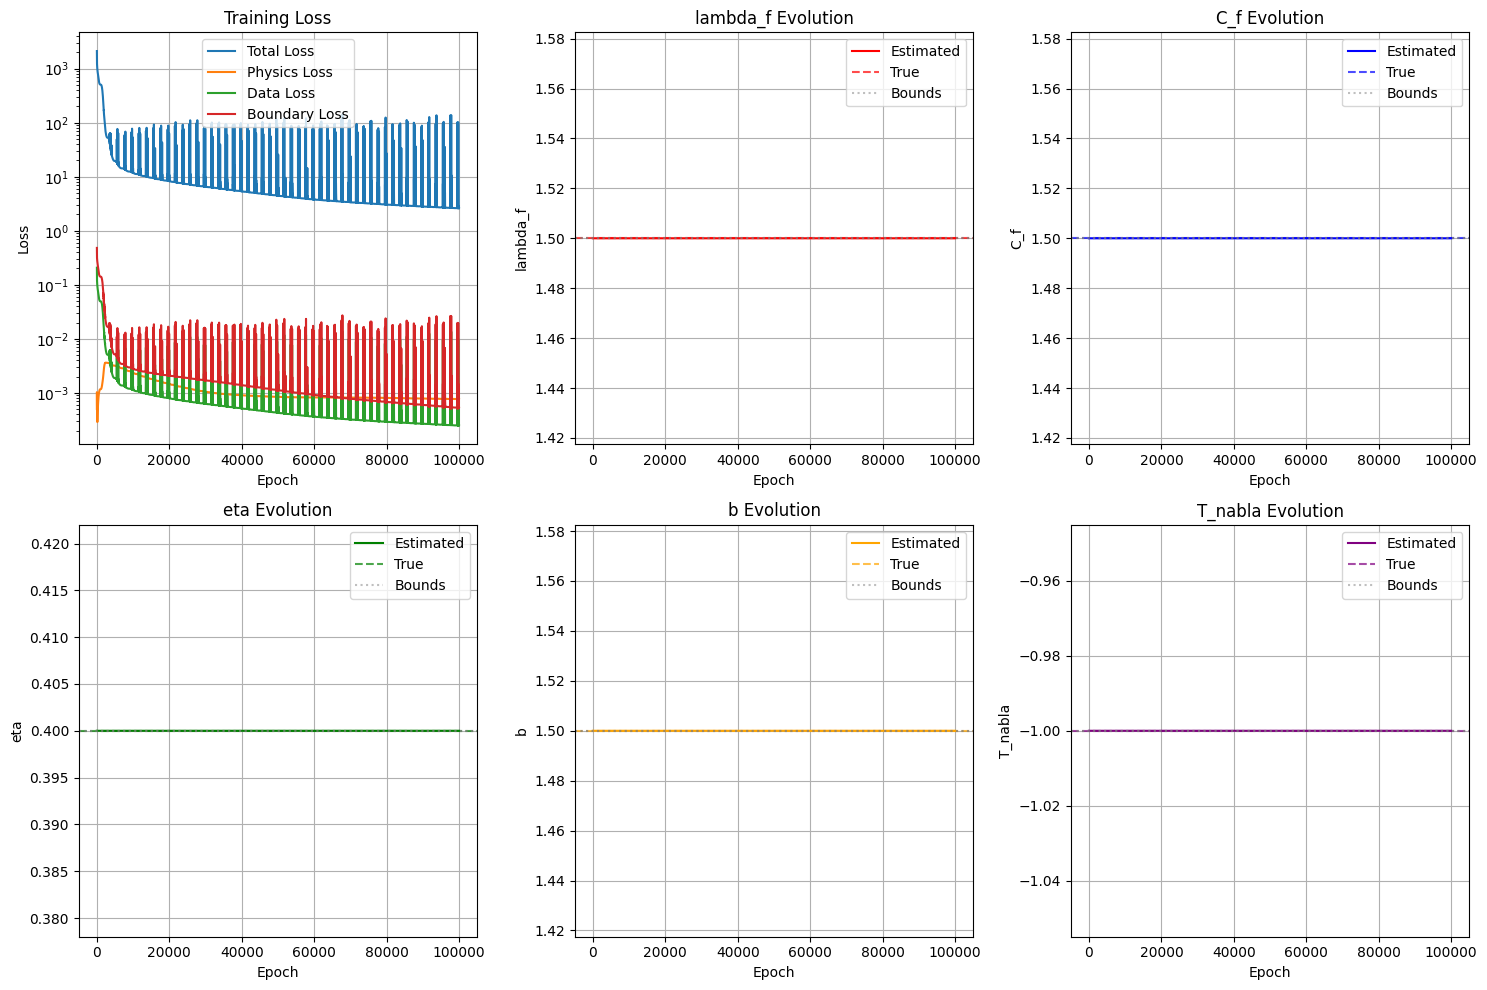


最终反演参数:
lambda_f: 估计值=1.500, 真实值=1.500, 误差=0.0%
C_f: 估计值=1.500, 真实值=1.500, 误差=0.0%
eta: 估计值=0.400, 真实值=0.400, 误差=0.0%
b: 估计值=1.500, 真实值=1.500, 误差=0.0%
T_nabla: 估计值=-1.000, 真实值=-1.000, 误差=-0.0%

验证反演结果...
预测误差 - 平均值: 0.2083°C, 最大值: 1.7786°C

按深度分析误差:
深度 0.0m - 平均误差: 0.2371°C, 最大误差: 1.7786°C
深度 1.0m - 平均误差: 0.2396°C, 最大误差: 1.5527°C
深度 2.0m - 平均误差: 0.1921°C, 最大误差: 1.2118°C
深度 3.0m - 平均误差: 0.1733°C, 最大误差: 0.8967°C
深度 4.0m - 平均误差: 0.2303°C, 最大误差: 0.8735°C
深度 5.0m - 平均误差: 0.1772°C, 最大误差: 1.5554°C


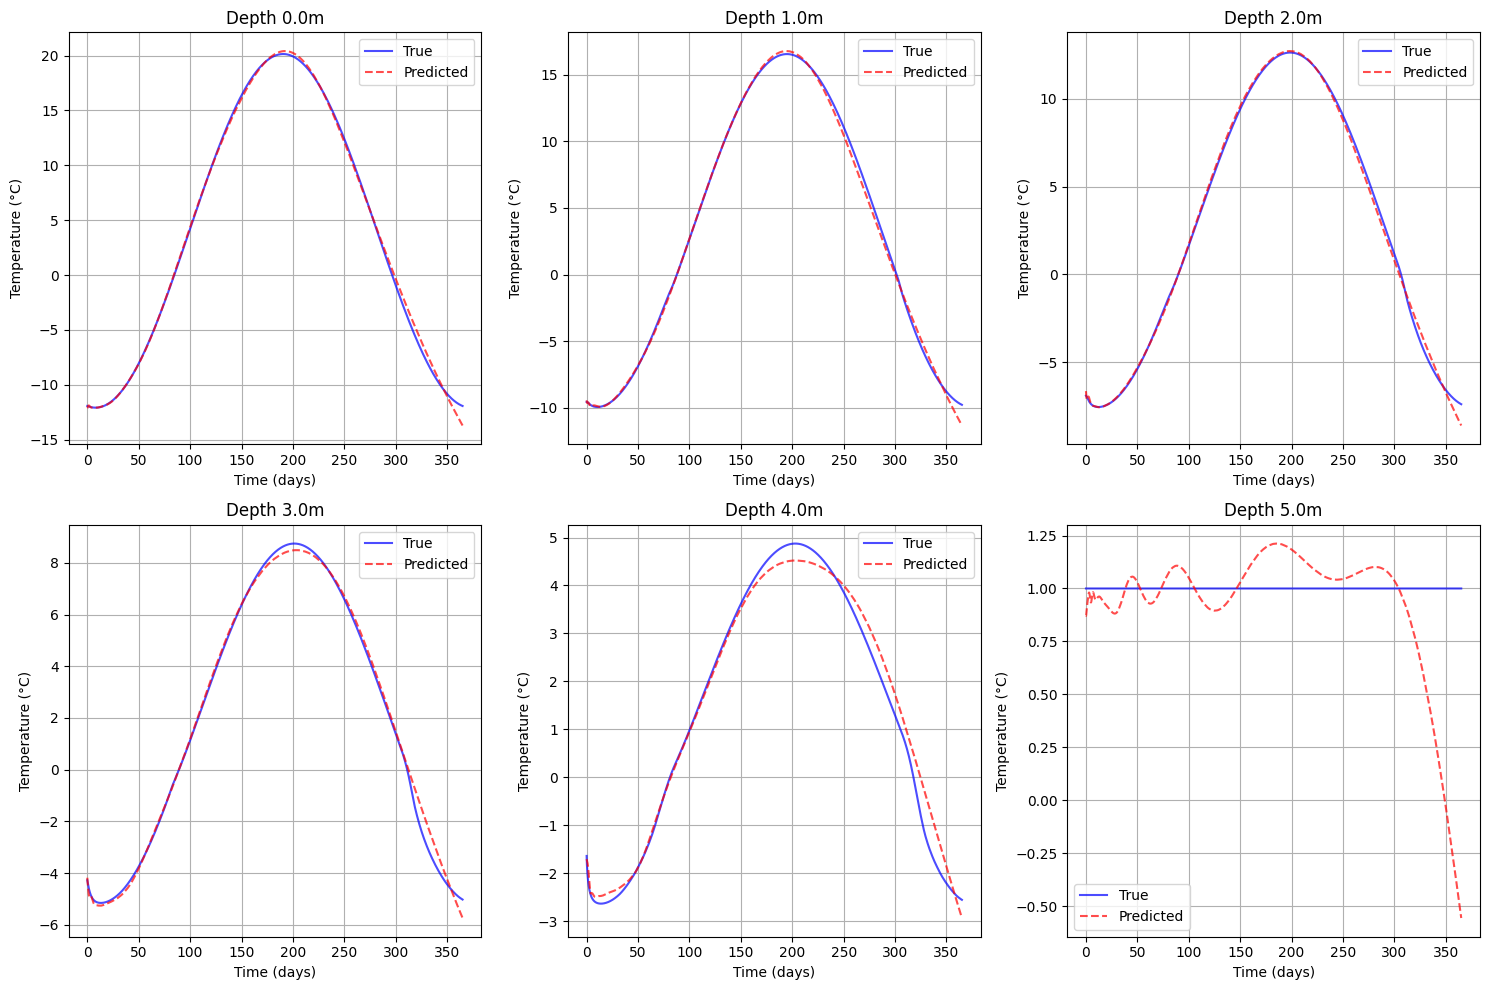

In [17]:
if __name__ == "__main__":
    main()

# Inversion using PINNs

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.interpolate import interp1d

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Neural network definition
class PhaseChangePINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f'linear_{i}', nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.net.add_module(f'tanh_{i}', nn.Tanh())
        # Parameter initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

class InversionFreezingSoilPINN:
    def __init__(self, known_params, param_bounds, device='cuda'):
        self.device = device
        
        # Known fixed parameters
        self.L = torch.tensor(known_params['L'], device=device)
        self.C_i = torch.tensor(known_params['C_i'], device=device)
        self.C_l = torch.tensor(known_params['C_l'], device=device)
        self.lambda_i = torch.tensor(known_params['lambda_i'], device=device)
        self.lambda_l = torch.tensor(known_params['lambda_l'], device=device)
        
        # Parameters to be estimated — initialize at the midpoint of bounds and set as trainable
        self.param_bounds = param_bounds
        self.param_names = list(param_bounds.keys())
        
        # Initialize using the midpoint of parameter ranges
        self.lambda_f = nn.Parameter(torch.tensor(
            (param_bounds['lambda_f'][0] + param_bounds['lambda_f'][1]) / 2, device=device))
        self.C_f = nn.Parameter(torch.tensor(
            (param_bounds['C_f'][0] + param_bounds['C_f'][1]) / 2, device=device))
        self.eta = nn.Parameter(torch.tensor(
            (param_bounds['eta'][0] + param_bounds['eta'][1]) / 2, device=device))
        self.b = nn.Parameter(torch.tensor(
            (param_bounds['b'][0] + param_bounds['b'][1]) / 2, device=device))
        self.T_nabla = nn.Parameter(torch.tensor(
            (param_bounds['T_nabla'][0] + param_bounds['T_nabla'][1]) / 2, device=device))
        
        # Parameter constraints
        self.param_constraints = {}
        for param_name, (min_val, max_val) in param_bounds.items():
            self.param_constraints[param_name] = (min_val, max_val)
        
        # Neural network (same architecture as forward PINNs)
        self.model = PhaseChangePINN([2, 50, 50, 50, 1]).to(device)
        
        # Optimizer needs to optimize both NN parameters and physical parameters
        self.optimizer = optim.Adam([
            {'params': self.model.parameters(), 'lr': 1e-4},
            {'params': [self.lambda_f, self.C_f, self.eta, self.b, self.T_nabla], 'lr': 1e-5}
        ])
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=1000)
        
        # Loss history
        self.loss_history = []
        self.pde_loss_history = []
        self.data_loss_history = []
        self.boundary_loss_history = []
        
        # Parameter history
        self.param_history = {name: [] for name in self.param_names}
        
        # Store boundary condition data
        self.boundary_data = None
        self.T_max = 20.0  # Default value, computed later
        self.boundary_interp_func = None  # Boundary interpolation function

    def apply_param_constraints(self):
        """Apply parameter constraints"""
        with torch.no_grad():
            for param_name, (min_val, max_val) in self.param_constraints.items():
                param = getattr(self, param_name)
                param.data = torch.clamp(param.data, min_val, max_val)

    def get_current_params(self):
        """Get current parameter values"""
        return {
            'lambda_f': self.lambda_f.item(),
            'C_f': self.C_f.item(),
            'eta': self.eta.item(),
            'b': self.b.item(),
            'T_nabla': self.T_nabla.item()
        }

    def _pore_water(self, T):
        """Pore water content calculation (same as forward PINNs)"""
        return torch.where(T >= self.T_nabla,
                          torch.ones_like(T),
                          torch.abs(self.T_nabla)**self.b * torch.abs(T)**(-self.b))

    def _unfrozen_water(self, T):
        """Unfrozen water content calculation (same as forward PINNs)"""
        return self.eta * self._pore_water(T)

    def _effective_heat_capacity(self, T):
        """Effective heat capacity calculation (same as forward PINNs)"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.C_f + self.eta*(phi*self.C_l + (1-phi)*self.C_i)

    def _effective_conductivity(self, T):
        """Effective thermal conductivity calculation (same as forward PINNs)"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.lambda_f + self.eta*(phi*self.lambda_l + (1-phi)*self.lambda_i)

    def _create_boundary_interp_func(self):
        """Create boundary interpolation function"""
        if self.boundary_data is not None:
            time_points = self.boundary_data['time_days'].values
            temp_values = self.boundary_data['temperature_0m'].values
            # Create linear interpolation function
            self.boundary_interp_func = interp1d(time_points, temp_values, 
                                                kind='linear', bounds_error=False, 
                                                fill_value="extrapolate")
        else:
            self.boundary_interp_func = None

    def _boundary_temp(self, t):
        """Upper boundary temperature function (x=0) — read surface temperature directly from CSV"""
        # Handle tensor input
        if isinstance(t, torch.Tensor):
            t_np = t.detach().cpu().numpy().flatten()
            
            if self.boundary_interp_func is not None:
                # Use interpolation function
                temp_values = self.boundary_interp_func(t_np)
                return torch.tensor(temp_values / self.T_max, dtype=torch.float32, device=self.device).unsqueeze(1)
            else:
                # If no boundary data, use default
                temp_values = 4.03 + 16.11*np.sin(2*np.pi*t_np/365 - 1.709)
                return torch.tensor(temp_values / self.T_max, dtype=torch.float32, device=self.device).unsqueeze(1)
        else:
            # Scalar input
            t_scalar = t
            
            if self.boundary_interp_func is not None:
                return self.boundary_interp_func(t_scalar) / self.T_max
            else:
                return (4.03 + 16.11*np.sin(2*np.pi*t_scalar/365 - 1.709)) / self.T_max

    def compute_physics_loss(self, x, t):
        """Compute physics-constrained loss (same formulation as forward PINNs)"""
        T_pred = self.model(torch.cat([x, t], dim=1))
        
        # Compute gradients
        dT_dt = torch.autograd.grad(T_pred, t, grad_outputs=torch.ones_like(T_pred), 
                                   create_graph=True, retain_graph=True)[0]
        dT_dx = torch.autograd.grad(T_pred, x, grad_outputs=torch.ones_like(T_pred),
                                   create_graph=True, retain_graph=True)[0]
        d2T_dx2 = torch.autograd.grad(dT_dx, x, grad_outputs=torch.ones_like(dT_dx),
                                     create_graph=True, retain_graph=True)[0]
        
        # Material property calculations
        C_eff = self._effective_heat_capacity(T_pred)
        lambda_eff = self._effective_conductivity(T_pred)
        theta = self._unfrozen_water(T_pred)
        dtheta_dt = torch.autograd.grad(theta, t, grad_outputs=torch.ones_like(theta),
                                       create_graph=True, retain_graph=True)[0]
        
        # PDE residual (same as forward PINNs)
        pde_res = C_eff*dT_dt - lambda_eff*d2T_dx2 - self.L*dtheta_dt
        pde_loss = torch.mean(pde_res**2)
        
        return pde_loss

    def compute_data_loss(self, x_obs, t_obs, T_obs_true):
        """Compute observation data loss"""
        T_pred = self.model(torch.cat([x_obs, t_obs], dim=1))
        data_loss = torch.mean((T_pred - T_obs_true)**2)
        return data_loss

    def compute_boundary_loss(self, x, t):
        """Compute boundary condition loss"""
        T_pred = self.model(torch.cat([x, t], dim=1))
        
        # Upper boundary condition (x=0)
        bc0_mask = (x == 0).squeeze()
        bc0_loss = torch.tensor(0.0, device=self.device)
        if bc0_mask.any():
            bc0_pred = T_pred[bc0_mask]
            bc0_true = self._boundary_temp(t[bc0_mask])
            bc0_loss = torch.mean((bc0_pred - bc0_true)**2)
        
        # Lower boundary condition (x=5)
        bcL_mask = (x == 5).squeeze()
        bcL_loss = torch.tensor(0.0, device=self.device)
        if bcL_mask.any():
            bcL_pred = T_pred[bcL_mask]
            bcL_true = torch.ones_like(bcL_pred) * (1.0 / self.T_max)  # Lower boundary 1°C, normalized
            bcL_loss = torch.mean((bcL_pred - bcL_true)**2)
        
        return bc0_loss + bcL_loss

    def train(self, x_domain, t_domain, x_obs, t_obs, T_obs_true, epochs=30000):
        print("Start inversion training...")
        print(f"Intialized parameters: {self.get_current_params()}")
        
        # Compute T_max — get maximum directly from CSV data
        if self.boundary_data is not None:
            # Compute maximum over all depths
            temp_columns = [col for col in self.boundary_data.columns if col.startswith('temperature_')]
            self.T_max = self.boundary_data[temp_columns].max().max()
            # Create boundary interpolation function
            self._create_boundary_interp_func()
        else:
            # If no boundary data, use max of default boundary function
            t_test = np.linspace(t_domain[0], t_domain[1], 1000)
            boundary_temps = [4.03 + 16.11*np.sin(2*np.pi*t_val/365 - 1.709) for t_val in t_test]
            self.T_max = max(boundary_temps)
        
        print(f"T_max (scaling factor): {self.T_max}")
        
        # Generate training data points (same sampling strategy as forward PINNs)
        n_samples = 10000
        x = torch.rand(n_samples, 1, device=self.device) * (x_domain[1] - x_domain[0]) + x_domain[0]
        t = torch.rand(n_samples, 1, device=self.device) * (t_domain[1] - t_domain[0]) + t_domain[0]
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        # Add boundary points (enforced sampling)
        bc0_points = torch.zeros(500, 1, device=self.device)
        bc0_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        bcL_points = torch.ones(500, 1, device=self.device)*5.0
        bcL_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        
        x = torch.cat([x, bc0_points, bcL_points])
        t = torch.cat([t, bc0_times, bcL_times])
        
        # Training loop
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            
            # Compute losses
            physics_loss = self.compute_physics_loss(x, t)
            data_loss = self.compute_data_loss(x_obs, t_obs, T_obs_true)
            boundary_loss = self.compute_boundary_loss(x, t)
            
            # Adjust loss weights; give higher weight to data loss
            total_loss = (1e2 * physics_loss + 
                        1e2 * boundary_loss + 
                        1e5 * data_loss)  # Data loss has the highest weight
            
            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            # Apply parameter constraints
            self.apply_param_constraints()
            
            # Record losses and parameters
            self.loss_history.append(total_loss.item())
            self.pde_loss_history.append(physics_loss.item())
            self.data_loss_history.append(data_loss.item())
            self.boundary_loss_history.append(boundary_loss.item())
            
            current_params = self.get_current_params()
            for name in self.param_names:
                self.param_history[name].append(current_params[name])
            
            # Progress print
            if epoch % 1000 == 0:
                print(f'Epoch {epoch:5d}, Total Loss: {total_loss.item():.3e}')
                print(f'  Physics: {physics_loss.item():.3e}, Data: {data_loss.item():.3e}, Boundary: {boundary_loss.item():.3e}')
                print(f'  Current params: {current_params}')
                
        return self.loss_history

    def predict(self, x, t):
        with torch.no_grad():
            xt = torch.cat([x, t], dim=1)
            return self.model(xt) * self.T_max  # Denormalize

def load_fdm_data_from_csv(csv_file='fdm_observation_data.csv'):
    """Load FDM observation data from a CSV file"""
    df = pd.read_csv(csv_file)
    
    print(f" from{csv_file} loading data successfully ")
    print(f"Data Shape: {df.shape}")
    print(f"Colunmn name: {list(df.columns)}")
    
    # Extract time data
    t_days = df['time_days'].values
    
    # Extract temperature data
    temperature_data = {}
    obs_depths = []
    
    for col in df.columns:
        if col.startswith('temperature_'):
            # Extract depth value
            depth_str = col.replace('temperature_', '').replace('m', '')
            depth = float(depth_str)
            obs_depths.append(depth)
            temperature_data[depth] = df[col].values
    
    print(f"Depth: {sorted(obs_depths)}m")
    print(f"Time length: {len(t_days)}")
    print(f"Time range: {t_days[0]:.1f} 到 {t_days[-1]:.1f} days")
    
    return df, t_days, temperature_data, obs_depths

def prepare_observation_data_from_csv(csv_file='fdm_observation_data.csv'):
    """Prepare observation data from CSV for inversion"""
    df, t_days, temperature_data, obs_depths = load_fdm_data_from_csv(csv_file)
    
    # Compute max temperature for normalization
    all_temps = np.concatenate([temperature_data[depth] for depth in obs_depths])
    T_max = np.max(all_temps)
    
    # Build observation tensors
    x_obs_list = []
    t_obs_list = []
    T_obs_list = []
    
    for depth in obs_depths:
        temp_vals = temperature_data[depth]
        for i, t_val in enumerate(t_days):
            x_obs_list.append([depth])
            t_obs_list.append([t_val])
            T_obs_list.append([temp_vals[i] / T_max])  # Normalize
    
    x_obs = torch.tensor(x_obs_list, dtype=torch.float32)
    t_obs = torch.tensor(t_obs_list, dtype=torch.float32)
    T_obs = torch.tensor(T_obs_list, dtype=torch.float32)
    
    print(f"Obs data shape: x_obs={x_obs.shape}, t_obs={t_obs.shape}, T_obs={T_obs.shape}")
    print(f"Normalized temperature range: {T_obs.min():.4f} to {T_obs.max():.4f}")
    
    return df, x_obs, t_obs, T_obs, obs_depths, T_max

def plot_inversion_results(inversion_model, true_params=None):
    """Plot inversion results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Loss curves
    ax = axes[0, 0]
    ax.semilogy(inversion_model.loss_history, label='Total Loss')
    ax.semilogy(inversion_model.pde_loss_history, label='Physics Loss')
    ax.semilogy(inversion_model.data_loss_history, label='Data Loss')
    ax.semilogy(inversion_model.boundary_loss_history, label='Boundary Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title('Training Loss')
    ax.grid(True)
    
    # Parameter evolution
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for idx, param_name in enumerate(inversion_model.param_names):
        ax = axes[(idx+1)//3, (idx+1)%3]
        param_history = inversion_model.param_history[param_name]
        ax.plot(param_history, color=colors[idx], label='Estimated')
        
        # True value (if known)
        if true_params and param_name in true_params:
            ax.axhline(y=true_params[param_name], color=colors[idx], 
                      linestyle='--', label='True', alpha=0.7)
        
        # Parameter bounds
        min_val, max_val = inversion_model.param_bounds[param_name]
        ax.axhline(y=min_val, color='gray', linestyle=':', alpha=0.5, label='Bounds')
        ax.axhline(y=max_val, color='gray', linestyle=':', alpha=0.5)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel(param_name)
        ax.legend()
        ax.set_title(f'{param_name} Evolution')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print final parameters
    final_params = inversion_model.get_current_params()
    print("\n Final inverted parameters:")
    for param_name in inversion_model.param_names:
        true_val = true_params.get(param_name, None) if true_params else None
        estimated_val = final_params[param_name]
        if true_val is not None:
            error = abs(estimated_val - true_val) / true_val * 100
            print(f"{param_name}: Estimated values={estimated_val:.3f}, Real values={true_val:.3f}, Errors={error:.1f}%")
        else:
            print(f"{param_name}: {estimated_val:.3f}")

def validate_inversion_results(inversion_model, x_obs, t_obs, T_obs_true, obs_depths, T_max):
    """Validate inversion results"""
    print("\n Final inverted values...")
    
    # Predict using inverted parameters
    with torch.no_grad():
        T_pred = inversion_model.predict(x_obs, t_obs)  # Already denormalized
    
    # Denormalize ground truth
    T_obs_true_denorm = T_obs_true * T_max
    
    # Compute prediction error
    pred_error = torch.abs(T_pred - T_obs_true_denorm)
    mean_error = torch.mean(pred_error).item()
    max_error = torch.max(pred_error).item()
    
    print(f"Error - Mean: {mean_error:.4f}°C, Max: {max_error:.4f}°C")
    
    # Error by depth
    print("\n Error over depths:")
    unique_depths = torch.unique(x_obs).cpu().numpy()
    
    for depth in unique_depths:
        depth_mask = (x_obs == depth).squeeze()
        depth_errors = pred_error[depth_mask]
        depth_mean_error = torch.mean(depth_errors).item()
        depth_max_error = torch.max(depth_errors).item()
        print(f"Depths {depth}m - Mean error: {depth_mean_error:.4f}°C, Max error: {depth_max_error:.4f}°C")
    
    # Plot predicted vs true
    plt.figure(figsize=(15, 10))
    
    # Subplots for each depth
    for i, depth in enumerate(sorted(unique_depths)):
        depth_mask = (x_obs == depth).squeeze()
        depth_t = t_obs[depth_mask].cpu().numpy()
        depth_T_true = T_obs_true_denorm[depth_mask].cpu().numpy()
        depth_T_pred = T_pred[depth_mask].cpu().numpy()
        
        plt.subplot(2, 3, i+1)
        plt.plot(depth_t, depth_T_true, 'b-', label='True', alpha=0.7, linewidth=1.5)
        plt.plot(depth_t, depth_T_pred, 'r--', label='Predicted', alpha=0.7, linewidth=1.5)
        plt.title(f'Depth {depth}m')
        plt.xlabel('Time (days)')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Main execution function
def main():
    # Known parameters
    known_params = {
        'L': 3.34e5,
        'C_i': 1.672,
        'C_l': 4.18,
        'lambda_i': 2.210,
        'lambda_l': 0.465
    }
    
    # Parameter bounds should allow variability
    param_bounds = {
        'lambda_f': [1.1, 1.8],    # Thermal conductivity of soil matrix
        'C_f': [1.1, 1.8],         # Heat capacity of soil matrix
        'eta': [0.4, 0.4],         # Porosity
        'b': [1.4, 1.6],           # Coefficient for unfrozen water
        'T_nabla': [-1.5, -0.5]    # Freezing temperature
    }
    
    # True parameter values (for validation)
    true_params = {
        'lambda_f': 1.5,
        'C_f': 1.5,
        'eta': 0.4,
        'b': 1.5,
        'T_nabla': -1.0
    }
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")
    
    # Load observation data from CSV
    try:
        df, x_obs, t_obs, T_obs_true, obs_depths, T_max = prepare_observation_data_from_csv('fdm_observation_data.csv')
    except Exception as e:
        print(f" Loading CSV data failure: {e}")
        print("Clarify the CSV data format")
        return
    
    # Move data to device
    x_obs = x_obs.to(device)
    t_obs = t_obs.to(device)
    T_obs_true = T_obs_true.to(device)
    
    # Initialize inversion model
    inversion_model = InversionFreezingSoilPINN(known_params, param_bounds, device)
    
    # Pass boundary data to model
    inversion_model.boundary_data = df
    
    # Train inversion model
    loss_history = inversion_model.train(
        x_domain=(0.0, 5.0),
        t_domain=(0.0, 365.0),
        x_obs=x_obs,
        t_obs=t_obs,
        T_obs_true=T_obs_true,
        epochs=100000
    )
    
    # Plot inversion results
    plot_inversion_results(inversion_model, true_params)
    
    # Validate inversion results
    validate_inversion_results(inversion_model, x_obs, t_obs, T_obs_true, obs_depths, T_max)


In [ ]:
if __name__ == "__main__":
    main()

Device: cuda
 fromfdm_observation_data.csv loading data successfully 
Data Shape: (100000, 7)
Colunmn name: ['time_days', 'temperature_0m', 'temperature_1m', 'temperature_2m', 'temperature_3m', 'temperature_4m', 'temperature_5m']
Depth: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]m
Time length: 100000
Time range: 0.0 到 365.0 days
Obs data shape: x_obs=torch.Size([600000, 1]), t_obs=torch.Size([600000, 1]), T_obs=torch.Size([600000, 1])
Normalized temperature range: -0.5998 to 1.0000
Start inversion training...
Intialized parameters: {'lambda_f': 1.4500000476837158, 'C_f': 1.4500000476837158, 'eta': 0.4000000059604645, 'b': 1.5, 'T_nabla': -1.0}
T_max (scaling factor): 20.139999994384475
Epoch     0, Total Loss: 2.077e+04
  Physics: 4.925e-04, Data: 2.072e-01, Boundary: 4.808e-01
  Current params: {'lambda_f': 1.4499900341033936, 'C_f': 1.4499900341033936, 'eta': 0.4000000059604645, 'b': 1.5, 'T_nabla': -1.0}
Epoch  1000, Total Loss: 4.962e+03
  Physics: 1.111e-03, Data: 4.948e-02, Boundary: 1.422e-0